# Multi-Window Diffusion Model Analysis

This notebook provides comprehensive visualization and analysis of diffusion model results across different prediction windows (1, 2, 3, 5, 10, 15 frames).

## Features:
- Temporal evolution analysis with polar plots
- Performance comparison across prediction windows
- Uncertainty quantification from multiple generations
- Condition frame vs prediction frame analysis
- Performance metrics (MSE, SSIM, etc.)


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torch
import json
from pathlib import Path
import random
from scipy.interpolate import griddata
from scipy.stats import pearsonr
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from skimage.metrics import structural_similarity as ssim
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

## Configuration and Data Loading

In [53]:
# Configuration - Update these paths to match your generation results
RESULTS_DIRS = {
    1:  "/mnt/nas05/data01/francesco/progetto_simone/ionosphere/generated_data/generation_results_1frame",
    2:  "/mnt/nas05/data01/francesco/progetto_simone/ionosphere/generated_data/generation_results_2frame", 
    3:  "/mnt/nas05/data01/francesco/progetto_simone/ionosphere/generated_data/generation_results_3frame",
    5:  "/mnt/nas05/data01/francesco/progetto_simone/ionosphere/generated_data/generation_results_5frame",
    10: "/mnt/nas05/data01/francesco/progetto_simone/ionosphere/generated_data/generation_results_10frame",
    15: "/mnt/nas05/data01/francesco/progetto_simone/ionosphere/generated_data/generation_results_15frame"
}

# Normalization factor from your dataset
NORMALIZATION_FACTOR = 108154.0

# Number of conditioning frames
CONDITIONING_FRAMES = 15

print("Available prediction windows:", list(RESULTS_DIRS.keys()))
print(f"Conditioning frames: {CONDITIONING_FRAMES}")

Available prediction windows: [1, 2, 3, 5, 10, 15]
Conditioning frames: 15


In [54]:
def load_sample_data(results_dir, sample_idx):
    """Load all data for a specific sample."""
    sample_dir = Path(results_dir) / f"sample_{sample_idx:04d}"
    
    if not sample_dir.exists():
        return None
    
    data = {}
    
    # Load arrays
    data['conditioning_input'] = np.load(sample_dir / "conditioning_input.npy")
    data['ground_truth'] = np.load(sample_dir / "ground_truth_frames.npy")
    data['generated_samples'] = np.load(sample_dir / "generated_samples.npy")
    data['generated_mean'] = np.load(sample_dir / "generated_mean.npy")
    data['generated_std'] = np.load(sample_dir / "generated_std.npy")
    data['conditions_original'] = np.load(sample_dir / "condition_labels_original.npy")
    
    # Load metadata
    with open(sample_dir / "metadata.json", 'r') as f:
        data['metadata'] = json.load(f)
    
    return data

def get_available_samples(results_dir):
    """Get list of available sample indices in results directory."""
    results_path = Path(results_dir)
    if not results_path.exists():
        return []
    
    sample_dirs = [d for d in results_path.iterdir() if d.is_dir() and d.name.startswith('sample_')]
    sample_indices = [int(d.name.split('_')[1]) for d in sample_dirs]
    return sorted(sample_indices)

# Test data loading
print("Testing data loading...")
for pred_window, results_dir in RESULTS_DIRS.items():
    available_samples = get_available_samples(results_dir)
    print(f"Prediction window {pred_window:2d}: {len(available_samples)} samples available")
    if available_samples:
        test_data = load_sample_data(results_dir, available_samples[0])
        if test_data:
            print(f"  Sample 0 shapes: cond={test_data['conditioning_input'].shape}, "
                  f"gt={test_data['ground_truth'].shape}, gen={test_data['generated_samples'].shape}")

Testing data loading...
Prediction window  1: 100 samples available
  Sample 0 shapes: cond=(15, 24, 360), gt=(1, 24, 360), gen=(5, 1, 24, 360)
Prediction window  2: 100 samples available
  Sample 0 shapes: cond=(15, 24, 360), gt=(2, 24, 360), gen=(5, 2, 24, 360)
Prediction window  3: 100 samples available
  Sample 0 shapes: cond=(15, 24, 360), gt=(3, 24, 360), gen=(5, 3, 24, 360)
Prediction window  5: 100 samples available
  Sample 0 shapes: cond=(15, 24, 360), gt=(5, 24, 360), gen=(5, 5, 24, 360)
Prediction window 10: 100 samples available
  Sample 0 shapes: cond=(15, 24, 360), gt=(10, 24, 360), gen=(5, 10, 24, 360)
Prediction window 15: 100 samples available
  Sample 0 shapes: cond=(15, 24, 360), gt=(15, 24, 360), gen=(5, 15, 24, 360)


## Utility Functions for Visualization

In [55]:
def revert_normalization(data_normalized):
    """Revert normalization to original scale."""
    return data_normalized * NORMALIZATION_FACTOR

def create_polar_plot_data(data):
    """Convert ionosphere data to polar coordinates for plotting."""
    # Handle single channel data
    if data.ndim > 2:
        data = data.squeeze()
    
    # Define coordinates
    mag_lat = np.linspace(-90, -66, data.shape[0])  # 24 latitude points
    mag_lon = np.linspace(0, 360, data.shape[1], endpoint=False)  # 360 longitude points
    
    # Create meshgrid from lat/lon
    lon_grid, lat_grid = np.meshgrid(mag_lon, mag_lat)
    
    # Convert to polar coordinates
    r = 90 - np.abs(lat_grid.flatten())
    theta = np.deg2rad(lon_grid.flatten())
    
    # Interpolate onto regular polar grid
    r_i = np.linspace(r.min(), r.max(), 100)
    theta_i = np.linspace(0, 2 * np.pi, 180)
    r_grid, theta_grid = np.meshgrid(r_i, theta_i)
    
    # Interpolation for data
    points = np.column_stack((r, theta))
    grid_values = griddata(points, data.flatten(), (r_grid, theta_grid), method='linear')
    
    return theta_grid, r_grid, grid_values

def plot_polar_ionosphere(ax, data, title, vmin=None, vmax=None, cmap='plasma'):
    """Plot ionosphere data in polar coordinates on given axis."""
    theta_grid, r_grid, grid_values = create_polar_plot_data(data)
    
    c = ax.pcolormesh(theta_grid, r_grid, grid_values, shading='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_theta_zero_location("S")
    ax.set_theta_direction(-1)
    ax.set_title(title, fontsize=10)
    
    return c

def calculate_metrics(pred, true):
    """Calculate various performance metrics."""
    # Flatten arrays for metric calculation
    pred_flat = pred.flatten()
    true_flat = true.flatten()
    
    metrics = {
        'mse': mean_squared_error(true_flat, pred_flat),
        'mae': mean_absolute_error(true_flat, pred_flat),
        'rmse': np.sqrt(mean_squared_error(true_flat, pred_flat)),
        'correlation': pearsonr(true_flat, pred_flat)[0],
        'max_diff': np.max(np.abs(true_flat - pred_flat)),
        'mean_diff': np.mean(true_flat - pred_flat)
    }
    
    # SSIM for 2D images
    if pred.ndim >= 2:
        try:
            metrics['ssim'] = ssim(true.squeeze(), pred.squeeze(), data_range=true.max() - true.min())
        except:
            metrics['ssim'] = np.nan
    
    return metrics

print("Utility functions loaded successfully!")

Utility functions loaded successfully!


## Detailed Performance Comparison

In [56]:
def compare_all_models_performance(max_samples=10):
    """
    Compare performance across all prediction windows for multiple samples.
    """
    print(f"🔍 COMPREHENSIVE MODEL COMPARISON")
    print(f"{'='*60}")
    
    # Collect performance data
    performance_data = []
    
    # Get common samples across all models
    common_samples = None
    for pred_window, results_dir in RESULTS_DIRS.items():
        available_samples = get_available_samples(results_dir)
        if common_samples is None:
            common_samples = set(available_samples)
        else:
            common_samples = common_samples.intersection(set(available_samples))
    
    common_samples = sorted(list(common_samples))[:max_samples]
    print(f"📊 Analyzing {len(common_samples)} common samples: {common_samples}")
    
    for sample_idx in tqdm(common_samples, desc="Processing samples"):
        for pred_window, results_dir in RESULTS_DIRS.items():
            data = load_sample_data(results_dir, sample_idx)
            if data is None:
                continue
            
            pred_mean = revert_normalization(data['generated_mean'])
            gt = revert_normalization(data['ground_truth'])
            std_data = revert_normalization(data['generated_std'])
            
            # Calculate metrics for each prediction frame
            for frame_idx in range(min(pred_mean.shape[0], gt.shape[0])):
                metrics = calculate_metrics(pred_mean[frame_idx], gt[frame_idx])
                metrics['uncertainty_mean'] = std_data[frame_idx].mean()
                metrics['uncertainty_max'] = std_data[frame_idx].max()
                
                performance_data.append({
                    'sample_idx': sample_idx,
                    'prediction_window': pred_window,
                    'frame_idx': frame_idx,
                    'timestep': CONDITIONING_FRAMES + frame_idx,
                    **metrics
                })
    
    # Convert to DataFrame for analysis
    df = pd.DataFrame(performance_data)
    
    print(f"📈 Collected {len(df)} data points")
    print(f"🎯 Prediction windows: {sorted(df['prediction_window'].unique())}")
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('Comprehensive Model Performance Comparison', fontsize=16)
    
    # Plot 1: MSE vs Prediction Window (First frame only)
    df_first_frame = df[df['frame_idx'] == 0]
    
    ax = axes[0, 0]
    sns.boxplot(data=df_first_frame, x='prediction_window', y='mse', ax=ax)
    ax.set_title('MSE vs Prediction Window\n(First Prediction Frame)')
    ax.set_ylabel('MSE')
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Correlation vs Prediction Window
    ax = axes[0, 1]
    sns.boxplot(data=df_first_frame, x='prediction_window', y='correlation', ax=ax)
    ax.set_title('Correlation vs Prediction Window\n(First Prediction Frame)')
    ax.set_ylabel('Correlation')
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Uncertainty vs Prediction Window
    ax = axes[0, 2]
    sns.boxplot(data=df_first_frame, x='prediction_window', y='uncertainty_mean', ax=ax)
    ax.set_title('Uncertainty vs Prediction Window\n(First Prediction Frame)')
    ax.set_ylabel('Mean Uncertainty (Std Dev)')
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Performance degradation over frames (for multi-frame models)
    ax = axes[1, 0]
    multi_frame_windows = df[df['prediction_window'] > 1]['prediction_window'].unique()
    for window in sorted(multi_frame_windows):
        window_data = df[df['prediction_window'] == window]
        frame_means = window_data.groupby('frame_idx')['mse'].mean()
        ax.plot(frame_means.index, frame_means.values, 'o-', label=f'Window {window}', linewidth=2)
    
    ax.set_xlabel('Prediction Frame Index')
    ax.set_ylabel('MSE')
    ax.set_title('MSE Degradation Over Prediction Frames')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 5: Correlation degradation over frames
    ax = axes[1, 1]
    for window in sorted(multi_frame_windows):
        window_data = df[df['prediction_window'] == window]
        frame_means = window_data.groupby('frame_idx')['correlation'].mean()
        ax.plot(frame_means.index, frame_means.values, 'o-', label=f'Window {window}', linewidth=2)
    
    ax.set_xlabel('Prediction Frame Index')
    ax.set_ylabel('Correlation')
    ax.set_title('Correlation Degradation Over Prediction Frames')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 6: Uncertainty evolution over frames
    ax = axes[1, 2]
    for window in sorted(multi_frame_windows):
        window_data = df[df['prediction_window'] == window]
        frame_means = window_data.groupby('frame_idx')['uncertainty_mean'].mean()
        ax.plot(frame_means.index, frame_means.values, 'o-', label=f'Window {window}', linewidth=2)
    
    ax.set_xlabel('Prediction Frame Index')
    ax.set_ylabel('Mean Uncertainty')
    ax.set_title('Uncertainty Evolution Over Prediction Frames')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 7: SSIM vs Prediction Window
    ax = axes[2, 0]
    df_valid_ssim = df_first_frame[df_first_frame['ssim'].notna()]
    if len(df_valid_ssim) > 0:
        sns.boxplot(data=df_valid_ssim, x='prediction_window', y='ssim', ax=ax)
        ax.set_title('SSIM vs Prediction Window\n(First Prediction Frame)')
        ax.set_ylabel('SSIM')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'SSIM data not available', ha='center', va='center', transform=ax.transAxes)
        ax.set_title('SSIM vs Prediction Window')
    
    # Plot 8: Performance summary table
    ax = axes[2, 1]
    ax.axis('off')
    
    # Create summary statistics
    summary_stats = df_first_frame.groupby('prediction_window').agg({
        'mse': ['mean', 'std'],
        'correlation': ['mean', 'std'],
        'uncertainty_mean': ['mean', 'std']
    }).round(4)
    
    table_data = []
    for window in sorted(df_first_frame['prediction_window'].unique()):
        mse_mean = summary_stats.loc[window, ('mse', 'mean')]
        mse_std = summary_stats.loc[window, ('mse', 'std')]
        corr_mean = summary_stats.loc[window, ('correlation', 'mean')]
        corr_std = summary_stats.loc[window, ('correlation', 'std')]
        unc_mean = summary_stats.loc[window, ('uncertainty_mean', 'mean')]
        unc_std = summary_stats.loc[window, ('uncertainty_mean', 'std')]
        
        table_data.append([
            f"W{int(window)}",
            f"{mse_mean:.2f}±{mse_std:.2f}",
            f"{corr_mean:.3f}±{corr_std:.3f}",
            f"{unc_mean:.2f}±{unc_std:.2f}"
        ])
    
    table = ax.table(cellText=table_data,
                    colLabels=['Window', 'MSE', 'Correlation', 'Uncertainty'],
                    cellLoc='center',
                    loc='center',
                    bbox=[0, 0, 1, 1])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    ax.set_title('Performance Summary Table\n(Mean ± Std)')
    
    # Plot 9: Sample variance across models
    ax = axes[2, 2]
    sample_variance = df_first_frame.groupby('sample_idx')['mse'].std()
    ax.hist(sample_variance, bins=10, alpha=0.7)
    ax.set_xlabel('MSE Standard Deviation Across Models')
    ax.set_ylabel('Frequency')
    ax.set_title('Sample-wise Performance Variance')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return df, summary_stats

print("Performance comparison function ready!")

Performance comparison function ready!


🚀 Starting comprehensive performance comparison...
🔍 COMPREHENSIVE MODEL COMPARISON
📊 Analyzing 20 common samples: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


Processing samples: 100%|██████████| 20/20 [00:03<00:00,  5.23it/s]


📈 Collected 720 data points
🎯 Prediction windows: [1, 2, 3, 5, 10, 15]


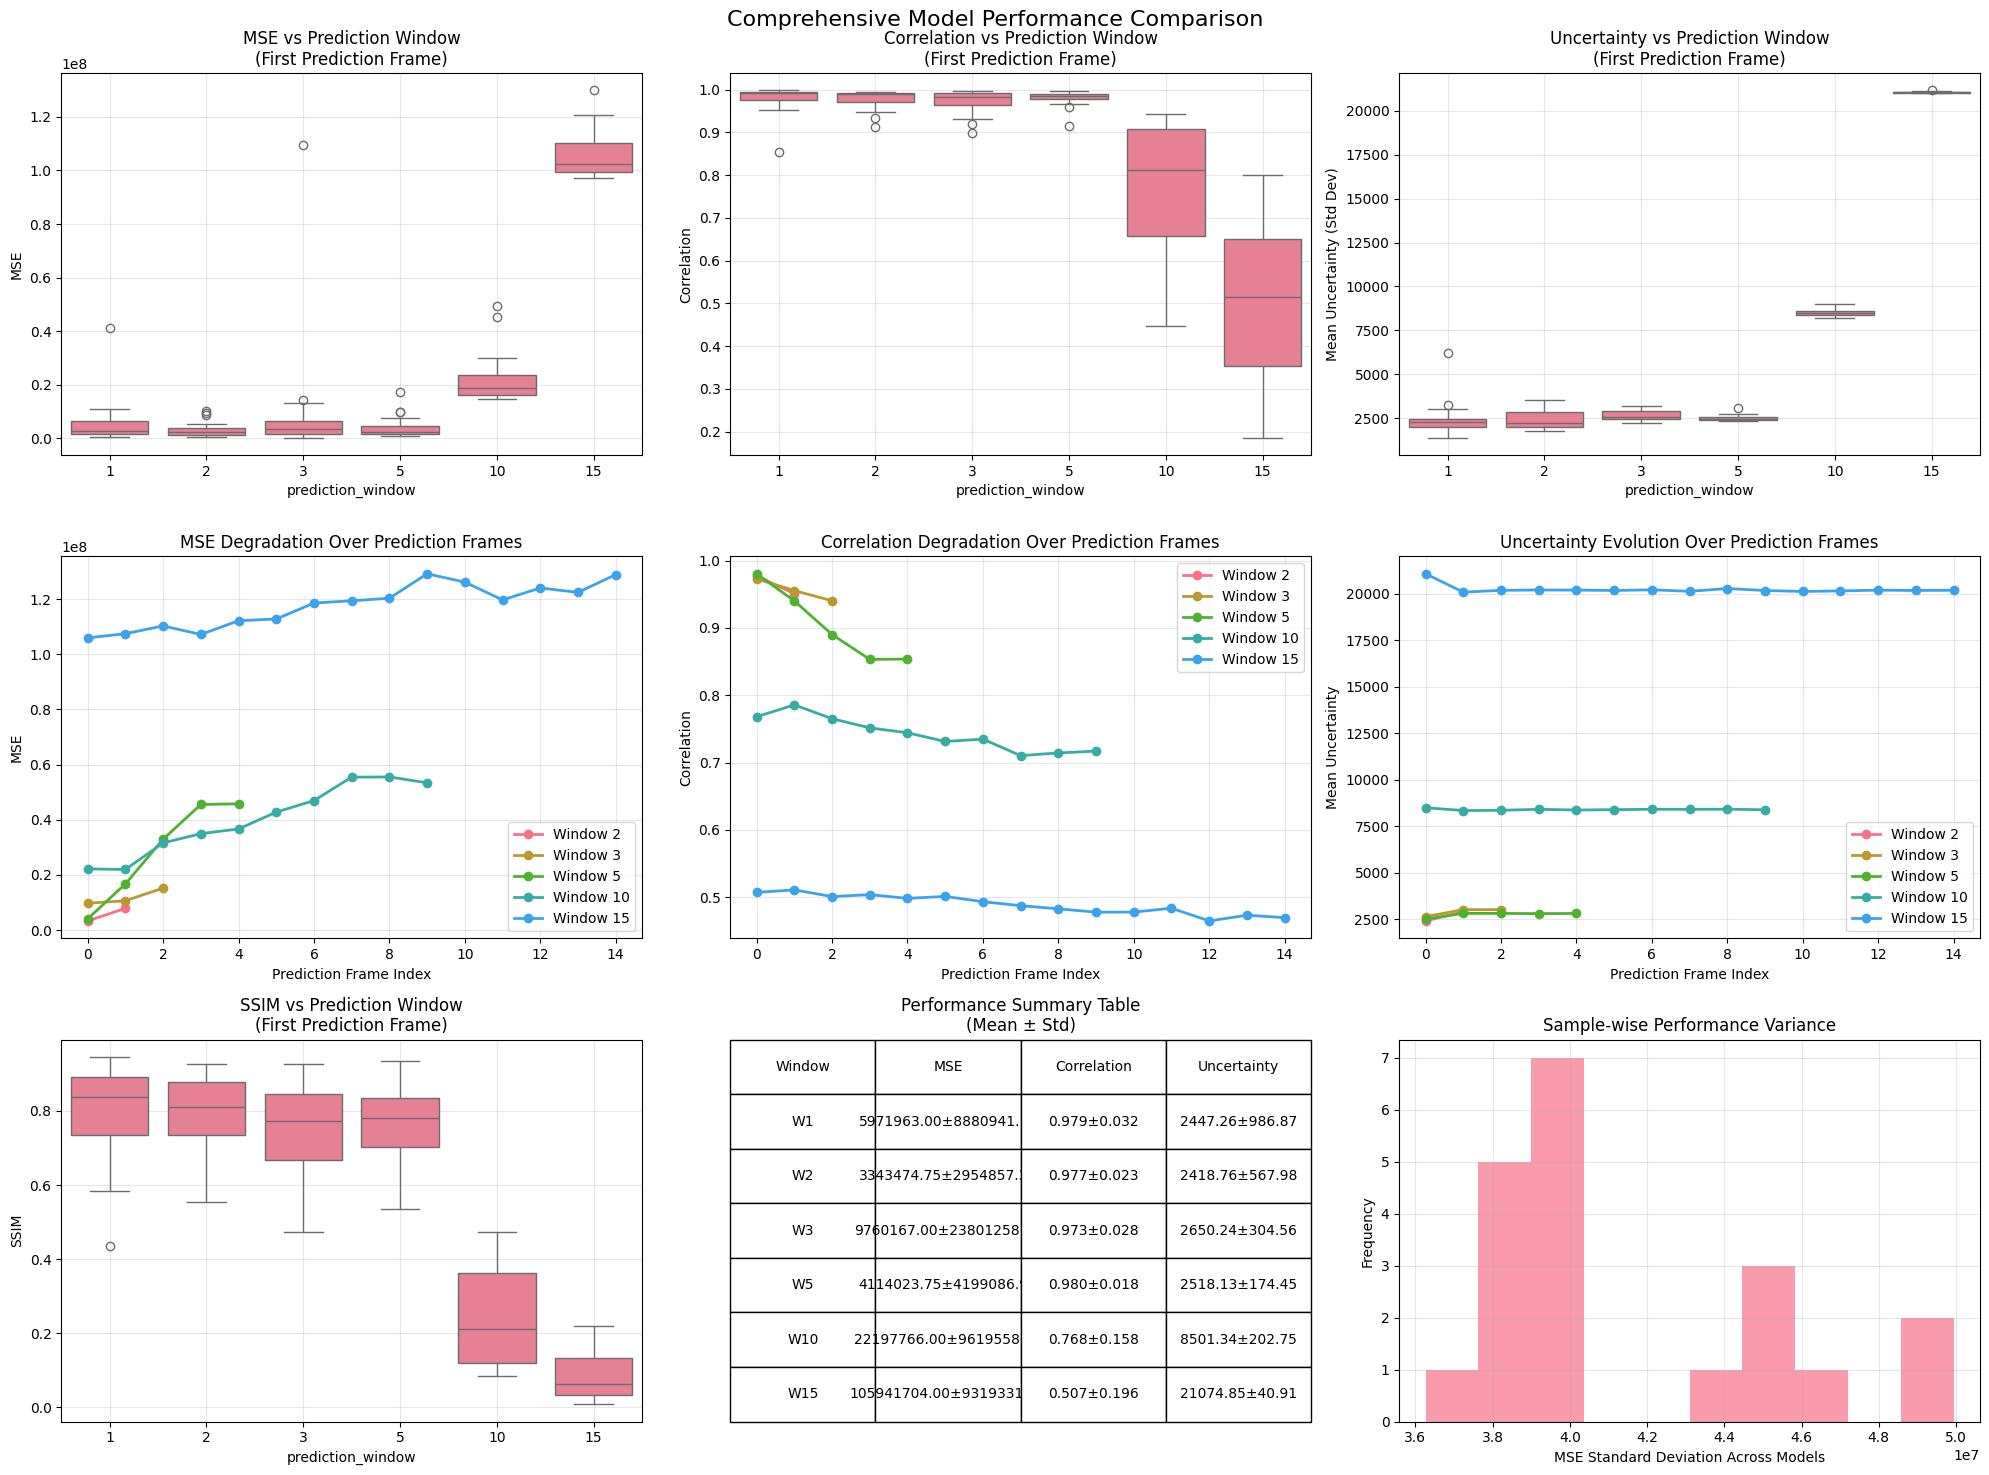

In [25]:
# Run comprehensive performance comparison
print("🚀 Starting comprehensive performance comparison...")
performance_df, summary_statistics = compare_all_models_performance(max_samples=20)

In [57]:
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec
import imageio
import os

def generate_comparison_gif(sample_data, pred_window, sample_idx, output_dir="gifs", fps=2):
    """Generate GIF with SEPARATE vmin/vmax for conditioning vs predicted frames."""
    print(f"Generating GIF for Sample {sample_idx}, Window {pred_window}")
    
    os.makedirs(output_dir, exist_ok=True)
    data = sample_data[pred_window]
    
    # Get data
    conditioning_input = revert_normalization(data['conditioning_input'])
    generated_mean = revert_normalization(data['generated_mean'])
    ground_truth = revert_normalization(data['ground_truth'])
    generated_std = revert_normalization(data['generated_std'])
    
    # SEPARATE SCALING AS REQUESTED
    # Conditioning vmin/vmax
    cond_vmin = conditioning_input.min()
    cond_vmax = conditioning_input.max()
    
    # Predicted frames vmin/vmax (sequence-wide for generated)
    pred_vmin = generated_mean.min()
    pred_vmax = generated_mean.max()
    gt_pred_vmin = ground_truth.min() 
    gt_pred_vmax = ground_truth.max()
    
    # Use generated sequence range for predicted frames
    pred_global_vmin = min(pred_vmin, gt_pred_vmin)
    pred_global_vmax = max(pred_vmax, gt_pred_vmax)
    
    print(f"  Conditioning range: [{cond_vmin:.1f}, {cond_vmax:.1f}]")
    print(f"  Predicted range: [{pred_global_vmin:.1f}, {pred_global_vmax:.1f}]")
    
    frames = []
    total_frames = generated_mean.shape[0]
    
    for frame_idx in range(total_frames):
        fig = plt.figure(figsize=(16, 8))
        
        # Generated frame
        ax1 = plt.subplot(1, 4, 1, polar=True)
        c1 = plot_polar_ionosphere(ax1, generated_mean[frame_idx], 
                                   f'Generated F{frame_idx+1}\\nW{pred_window}', 
                                   vmin=pred_global_vmin, vmax=pred_global_vmax)
        plt.colorbar(c1, ax=ax1, shrink=0.6)
        
        # Ground truth frame
        ax2 = plt.subplot(1, 4, 2, polar=True)
        c2 = plot_polar_ionosphere(ax2, ground_truth[frame_idx],
                                   f'GT F{frame_idx+1}\\nW{pred_window}',
                                   vmin=pred_global_vmin, vmax=pred_global_vmax)
        plt.colorbar(c2, ax=ax2, shrink=0.6)
        
        # Uncertainty
        ax3 = plt.subplot(1, 4, 3, polar=True)
        c3 = plot_polar_ionosphere(ax3, generated_std[frame_idx],
                                   f'Uncertainty\\nF{frame_idx+1}',
                                   vmin=0, vmax=generated_std.max(), cmap='Reds')
        plt.colorbar(c3, ax=ax3, shrink=0.6)
        
        # Min-max plot - FIXED FOR SINGLE FRAME
        ax4 = plt.subplot(1, 4, 4)
        
        if pred_window == 1:
            # For window 1: show single point
            ax4.scatter([0], [generated_mean[0].min()], color='blue', s=100, label='Gen Min', marker='o')
            ax4.scatter([0], [generated_mean[0].max()], color='blue', s=100, label='Gen Max', marker='^')
            ax4.scatter([0], [ground_truth[0].min()], color='red', s=100, label='GT Min', marker='o')
            ax4.scatter([0], [ground_truth[0].max()], color='red', s=100, label='GT Max', marker='^')
            ax4.set_xlim(-0.5, 0.5)
            ax4.set_xticks([0])
            ax4.set_xticklabels(['F1'])
        else:
            # For multi-frame: show lines up to current frame
            frame_indices = np.arange(frame_idx + 1)
            gen_mins = [generated_mean[i].min() for i in frame_indices]
            gen_maxs = [generated_mean[i].max() for i in frame_indices]
            gt_mins = [ground_truth[i].min() for i in frame_indices]
            gt_maxs = [ground_truth[i].max() for i in frame_indices]
            
            ax4.plot(frame_indices, gen_mins, 'b-', label='Gen Min', linewidth=2, marker='o')
            ax4.plot(frame_indices, gen_maxs, 'b--', label='Gen Max', linewidth=2, marker='^')
            ax4.plot(frame_indices, gt_mins, 'r-', label='GT Min', linewidth=2, marker='o')
            ax4.plot(frame_indices, gt_maxs, 'r--', label='GT Max', linewidth=2, marker='^')
            ax4.axvline(x=frame_idx, color='black', linestyle=':', alpha=0.7)
            ax4.set_xlim(-0.5, max(1, total_frames-0.5))
        
        ax4.set_ylabel('Value')
        ax4.set_title('Min-Max Evolution')
        ax4.legend(fontsize=8)
        ax4.grid(True, alpha=0.3)
        
        plt.suptitle(f'Sample {sample_idx} - Window {pred_window} - Frame {frame_idx+1}/{total_frames}', fontsize=14)
        plt.tight_layout()
        
        # Save frame
        frame_filename = f"/tmp/frame_{frame_idx:03d}.png"
        plt.savefig(frame_filename, dpi=100, bbox_inches='tight')
        frames.append(frame_filename)
        plt.close()
    
    # Create GIF
    gif_filename = f"{output_dir}/sample_{sample_idx:04d}_window_{pred_window:02d}.gif"
    duration_ms = int(1000 / fps)
    
    with imageio.get_writer(gif_filename, mode='I', duration=duration_ms, loop=0) as writer:
        for frame_file in frames:
            image = imageio.imread(frame_file)
            writer.append_data(image)
            os.remove(frame_file)
    
    print(f"  ✅ Saved: {gif_filename}")
    return gif_filename

print("✅ FIXED GIF generation ready!")

✅ FIXED GIF generation ready!



📊 Running comprehensive horizon comparison...
📊 COMPREHENSIVE HORIZON COMPARISON - Sample 5
📈 Available windows: [1, 2, 3, 5, 10, 15]
📊 Comprehensive comparison saved: comprehensive_horizon_comparison_sample_0005.png


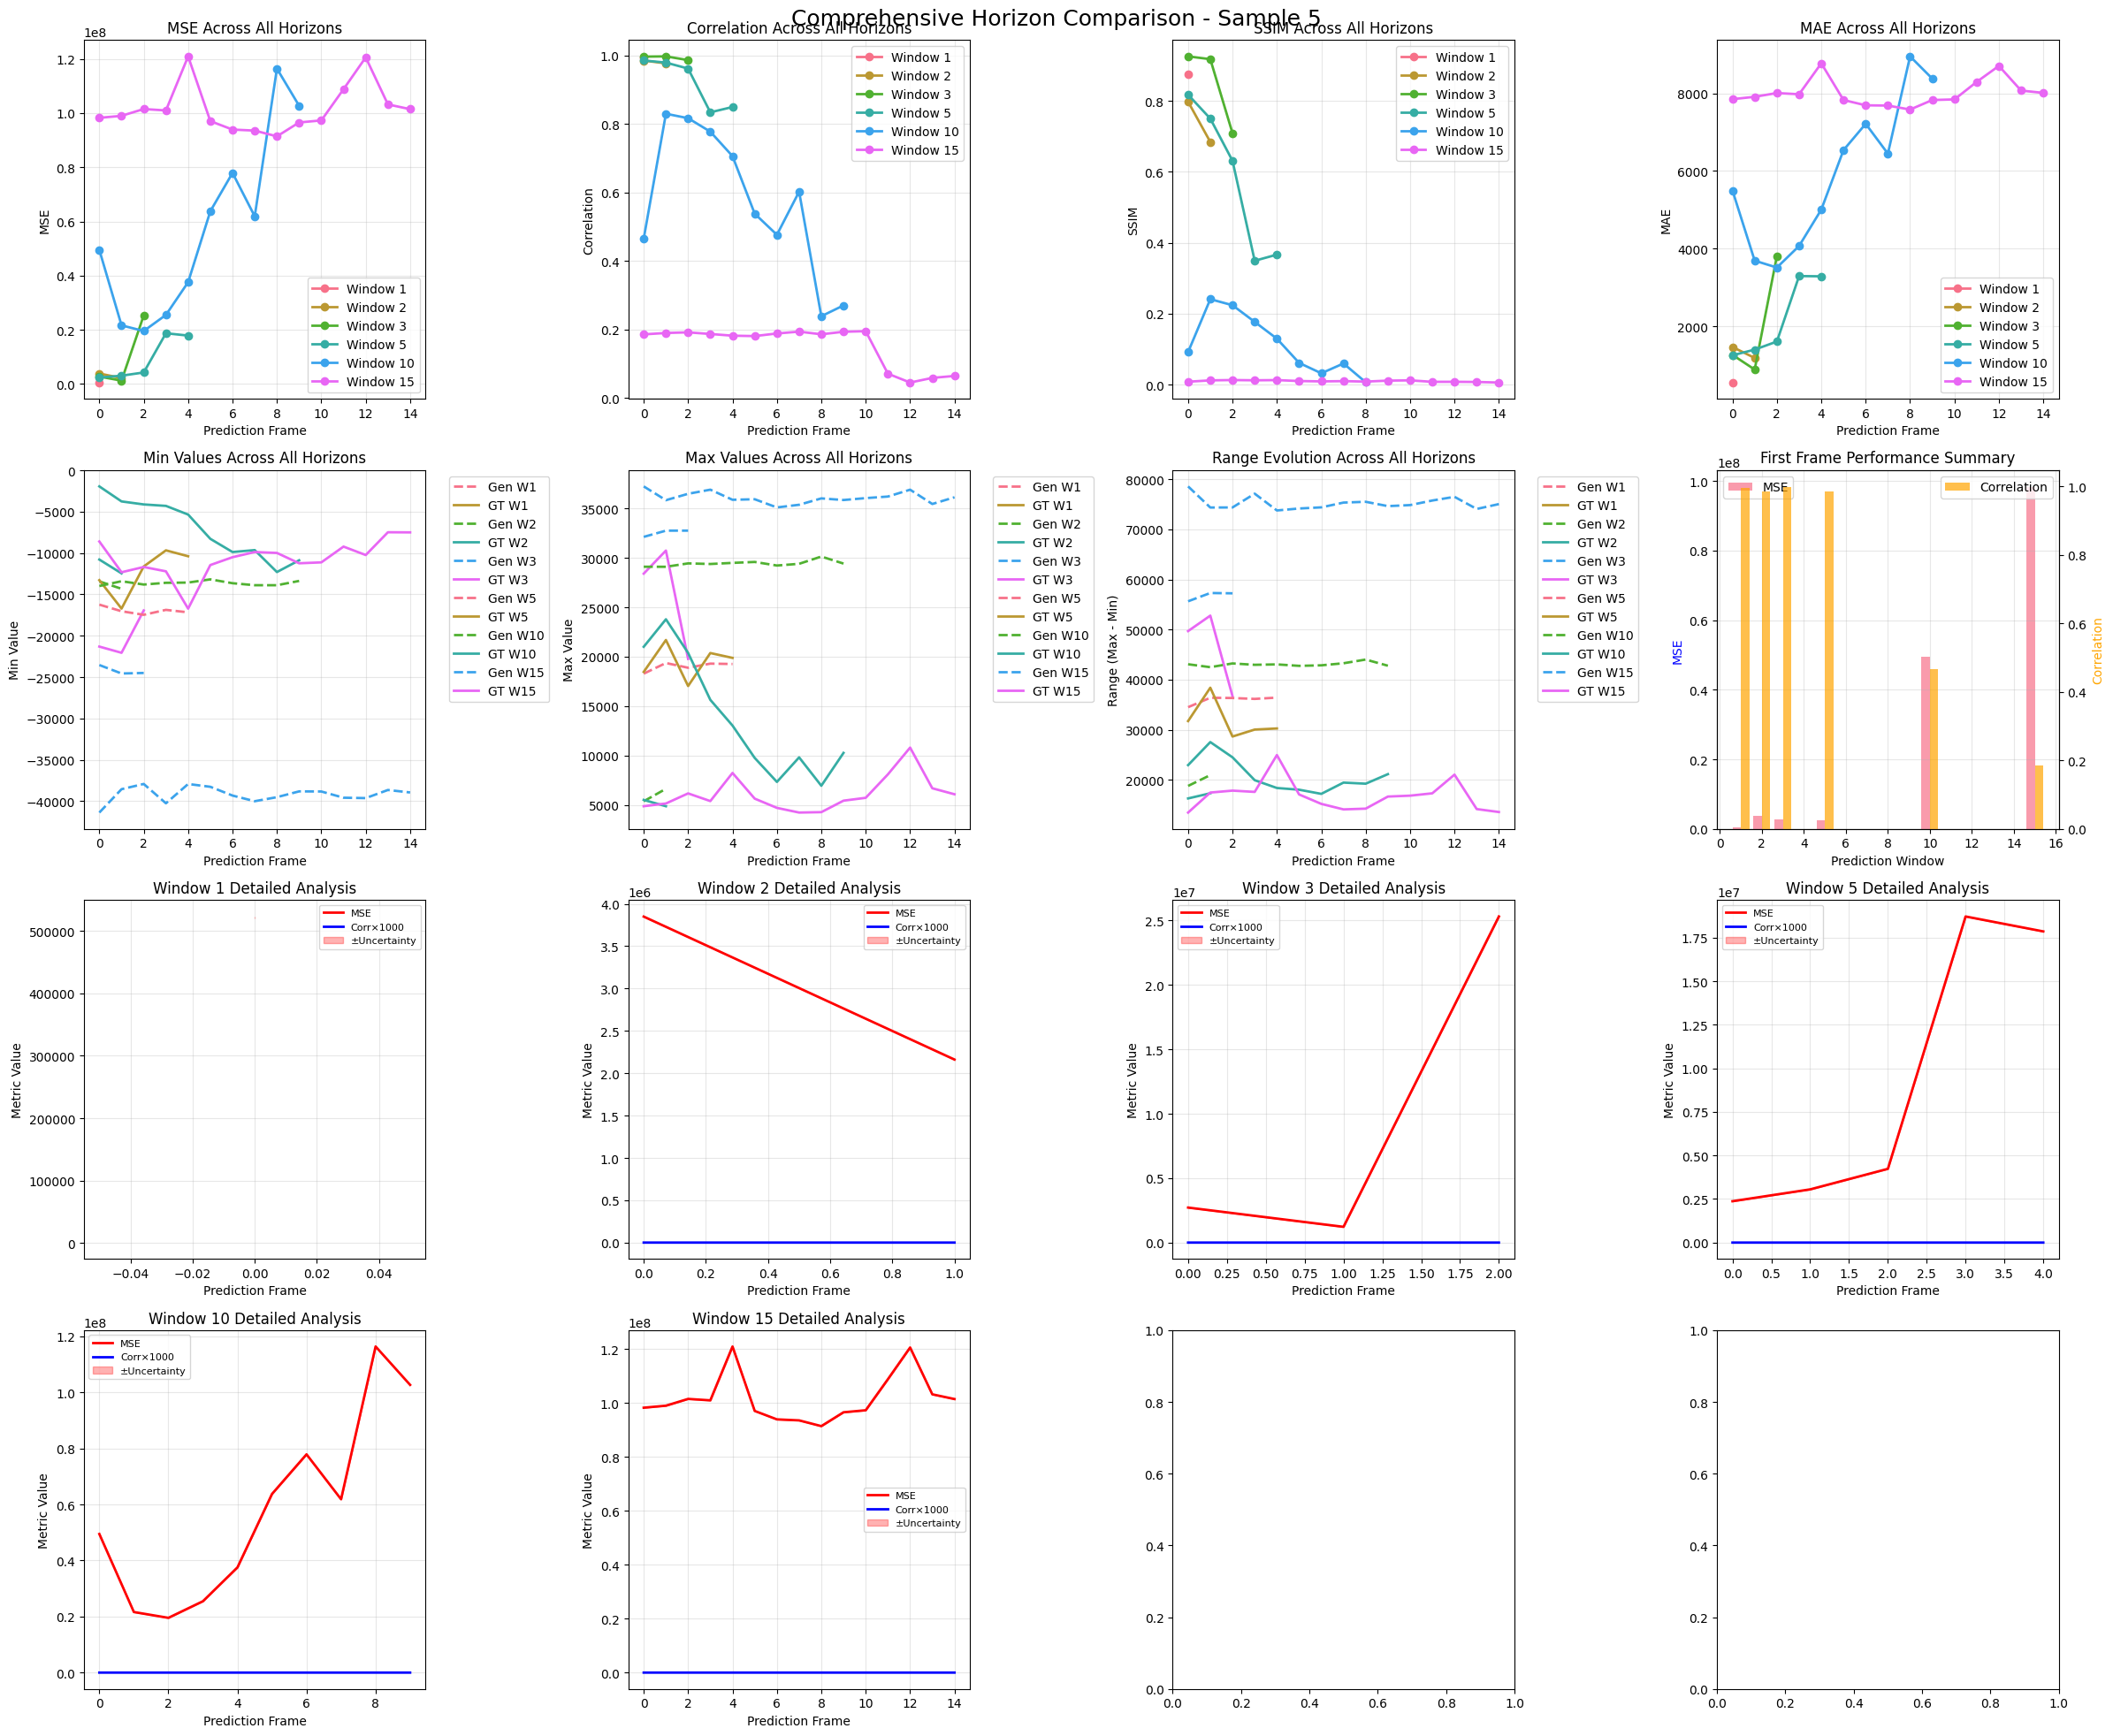

In [58]:
# Run comprehensive horizon comparison
print("\n📊 Running comprehensive horizon comparison...")
target_sample = 5
comparison_results = comprehensive_horizon_comparison(sample_idx=target_sample, save_plots=True)

## 🎬 Generate GIFs and Run Enhanced Analysis

In [59]:
def comprehensive_horizon_comparison(sample_idx=0, save_plots=True):
    """
    Comprehensive comparison across all horizon windows for all metrics.
    """
    print(f"📊 COMPREHENSIVE HORIZON COMPARISON - Sample {sample_idx}")
    print(f"{'='*70}")
    
    # Load data for all prediction windows
    all_sample_data = {}
    for pred_window in RESULTS_DIRS.keys():
        data = load_sample_data(RESULTS_DIRS[pred_window], sample_idx)
        if data is not None:
            all_sample_data[pred_window] = data
    
    if not all_sample_data:
        print("❌ No data found for the specified sample!")
        return None
    
    available_windows = sorted(all_sample_data.keys())
    print(f"📈 Available windows: {available_windows}")
    
    # Create comprehensive comparison figure
    fig, axes = plt.subplots(4, 4, figsize=(24, 20))
    fig.suptitle(f'Comprehensive Horizon Comparison - Sample {sample_idx}', fontsize=18)
    
    # Collect all metrics for each window
    all_metrics = {}
    minmax_data = {}
    
    for pred_window in available_windows:
        data = all_sample_data[pred_window]
        generated_mean = revert_normalization(data['generated_mean'])
        ground_truth = revert_normalization(data['ground_truth'])
        
        # Track min-max evolution
        minmax_data[pred_window] = track_minmax_evolution(all_sample_data, pred_window, sample_idx)
        
        # Calculate metrics for each frame
        window_metrics = {'frames': [], 'mse': [], 'correlation': [], 'ssim': [], 'mae': []}
        
        for frame_idx in range(min(generated_mean.shape[0], ground_truth.shape[0])):
            metrics = calculate_metrics(generated_mean[frame_idx], ground_truth[frame_idx])
            window_metrics['frames'].append(frame_idx)
            window_metrics['mse'].append(metrics['mse'])
            window_metrics['correlation'].append(metrics['correlation'])
            window_metrics['ssim'].append(metrics['ssim'] if not np.isnan(metrics['ssim']) else 0)
            window_metrics['mae'].append(metrics['mae'])
        
        all_metrics[pred_window] = window_metrics
    
    # Plot 1: MSE comparison across horizons
    ax = axes[0, 0]
    for pred_window in available_windows:
        metrics = all_metrics[pred_window]
        ax.plot(metrics['frames'], metrics['mse'], 'o-', label=f'Window {pred_window}', linewidth=2)
    ax.set_xlabel('Prediction Frame')
    ax.set_ylabel('MSE')
    ax.set_title('MSE Across All Horizons')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Correlation comparison
    ax = axes[0, 1]
    for pred_window in available_windows:
        metrics = all_metrics[pred_window]
        ax.plot(metrics['frames'], metrics['correlation'], 'o-', label=f'Window {pred_window}', linewidth=2)
    ax.set_xlabel('Prediction Frame')
    ax.set_ylabel('Correlation')
    ax.set_title('Correlation Across All Horizons')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: SSIM comparison
    ax = axes[0, 2]
    for pred_window in available_windows:
        metrics = all_metrics[pred_window]
        valid_ssim = [s for s in metrics['ssim'] if s > 0]
        if valid_ssim:
            ax.plot(metrics['frames'][:len(valid_ssim)], valid_ssim, 'o-', label=f'Window {pred_window}', linewidth=2)
    ax.set_xlabel('Prediction Frame')
    ax.set_ylabel('SSIM')
    ax.set_title('SSIM Across All Horizons')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 4: MAE comparison  
    ax = axes[0, 3]
    for pred_window in available_windows:
        metrics = all_metrics[pred_window]
        ax.plot(metrics['frames'], metrics['mae'], 'o-', label=f'Window {pred_window}', linewidth=2)
    ax.set_xlabel('Prediction Frame')
    ax.set_ylabel('MAE')
    ax.set_title('MAE Across All Horizons')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 5: Min values evolution
    ax = axes[1, 0]
    for pred_window in available_windows:
        minmax = minmax_data[pred_window]
        ax.plot(minmax['frame_indices'], minmax['gen_mins'], '--', label=f'Gen W{pred_window}', linewidth=2)
        ax.plot(minmax['frame_indices'], minmax['gt_mins'], '-', label=f'GT W{pred_window}', linewidth=2)
    ax.set_xlabel('Prediction Frame')
    ax.set_ylabel('Min Value')
    ax.set_title('Min Values Across All Horizons')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    # Plot 6: Max values evolution
    ax = axes[1, 1]
    for pred_window in available_windows:
        minmax = minmax_data[pred_window]
        ax.plot(minmax['frame_indices'], minmax['gen_maxs'], '--', label=f'Gen W{pred_window}', linewidth=2)
        ax.plot(minmax['frame_indices'], minmax['gt_maxs'], '-', label=f'GT W{pred_window}', linewidth=2)
    ax.set_xlabel('Prediction Frame')
    ax.set_ylabel('Max Value')
    ax.set_title('Max Values Across All Horizons')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    # Plot 7: Range evolution (max - min)
    ax = axes[1, 2]
    for pred_window in available_windows:
        minmax = minmax_data[pred_window]
        ax.plot(minmax['frame_indices'], minmax['gen_ranges'], '--', label=f'Gen W{pred_window}', linewidth=2)
        ax.plot(minmax['frame_indices'], minmax['gt_ranges'], '-', label=f'GT W{pred_window}', linewidth=2)
    ax.set_xlabel('Prediction Frame')
    ax.set_ylabel('Range (Max - Min)')
    ax.set_title('Range Evolution Across All Horizons')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    # Plot 8: First frame performance summary
    ax = axes[1, 3]
    first_frame_mse = [all_metrics[w]['mse'][0] for w in available_windows]
    first_frame_corr = [all_metrics[w]['correlation'][0] for w in available_windows]
    
    ax_twin = ax.twinx()
    bars1 = ax.bar([w - 0.2 for w in available_windows], first_frame_mse, 0.4, label='MSE', alpha=0.7)
    bars2 = ax_twin.bar([w + 0.2 for w in available_windows], first_frame_corr, 0.4, label='Correlation', alpha=0.7, color='orange')
    
    ax.set_xlabel('Prediction Window')
    ax.set_ylabel('MSE', color='blue')
    ax_twin.set_ylabel('Correlation', color='orange')
    ax.set_title('First Frame Performance Summary')
    ax.legend(loc='upper left')
    ax_twin.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Plot 9-16: Individual window detailed analysis
    for i, pred_window in enumerate(available_windows):
        if i >= 8:  # Limit to 8 detailed plots
            break
        
        row = 2 + i // 4
        col = i % 4
        ax = axes[row, col]
        
        # Get data for this specific window
        data = all_sample_data[pred_window]
        generated_mean = revert_normalization(data['generated_mean'])
        ground_truth = revert_normalization(data['ground_truth'])
        generated_std = revert_normalization(data['generated_std'])
        
        # Plot metrics evolution with uncertainty
        metrics = all_metrics[pred_window]
        ax.plot(metrics['frames'], metrics['mse'], 'r-', label='MSE', linewidth=2)
        ax.plot(metrics['frames'], np.array(metrics['correlation']) * 1000, 'b-', label='Corr×1000', linewidth=2)  # Scale for visibility
        
        # Add uncertainty shading
        uncertainty_means = [generated_std[f].mean() for f in range(len(metrics['frames']))]
        ax.fill_between(metrics['frames'], 
                       np.array(metrics['mse']) - np.array(uncertainty_means),
                       np.array(metrics['mse']) + np.array(uncertainty_means),
                       alpha=0.3, color='red', label='±Uncertainty')
        
        ax.set_xlabel('Prediction Frame')
        ax.set_ylabel('Metric Value')
        ax.set_title(f'Window {pred_window} Detailed Analysis')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_plots:
        plot_filename = f"comprehensive_horizon_comparison_sample_{sample_idx:04d}.png"
        plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
        print(f"📊 Comprehensive comparison saved: {plot_filename}")
    
    plt.show()
    
    return {
        'sample_idx': sample_idx,
        'available_windows': available_windows,
        'all_metrics': all_metrics,
        'minmax_data': minmax_data
    }

print("📊 Comprehensive horizon comparison function ready!")

📊 Comprehensive horizon comparison function ready!


In [23]:
# SIMPLE GIF GENERATION SCRIPT - RUN THIS CELL
target_sample = 5  

# Load sample data
sample_data = {}
for pred_window, results_dir in RESULTS_DIRS.items():
    data = load_sample_data(results_dir, target_sample)
    if data is not None:
        sample_data[pred_window] = data

print(f"Loaded data for windows: {sorted(sample_data.keys())}")

# Generate GIFs for each window
for pred_window in sorted(sample_data.keys()):
    print(f"Generating GIF for window {pred_window}...")
    try:
        gif_file = generate_comparison_gif(sample_data, pred_window, target_sample, 
                                         output_dir="sample_gifs", fps=1)
        print(f"✅ Generated: {gif_file}")
    except Exception as e:
        print(f"❌ Error: {e}")

print("Done!")

Loaded data for windows: [1, 2, 3, 5, 10, 15]
Generating GIF for window 1...
Generating GIF for Sample 5, Window 1
  Conditioning range: [-19702.4, 18487.3]
  Predicted range: [-14439.0, 12782.3]
  ✅ Saved: sample_gifs/sample_0005_window_01.gif
✅ Generated: sample_gifs/sample_0005_window_01.gif
Generating GIF for window 2...
Generating GIF for Sample 5, Window 2
  Conditioning range: [-25365.6, 7489.0]
  Predicted range: [-14325.5, 6632.7]
  ✅ Saved: sample_gifs/sample_0005_window_02.gif
✅ Generated: sample_gifs/sample_0005_window_02.gif
Generating GIF for window 3...
Generating GIF for Sample 5, Window 3
  Conditioning range: [-28519.1, 43860.2]
  Predicted range: [-24560.9, 32752.7]
  ✅ Saved: sample_gifs/sample_0005_window_03.gif
✅ Generated: sample_gifs/sample_0005_window_03.gif
Generating GIF for window 5...
Generating GIF for Sample 5, Window 5
  Conditioning range: [-24345.2, 21515.3]
  Predicted range: [-17468.8, 21688.3]
  ✅ Saved: sample_gifs/sample_0005_window_05.gif
✅ Gener

## 🎬 NEW: GIF Generation and Min-Max Analysis

This section adds the missing features you requested:
1. **Min-Max parameter tracking in predicted frames**
2. **GIF generation for generated vs true data per horizon**  
3. **Proper vmin/vmax scaling based on sequence-wide values**

## Usage Instructions

### To use this notebook:

1. **Update Configuration**: Modify the `RESULTS_DIRS` dictionary to point to your generated results directories

2. **Run Generation Script**: First run the `generate_multi_window.py` script for each model:
   ```bash
   python generate_multi_window.py --model_ckpt model_1.pth --config config_1.json --output_dir results_1_frame/ --num_generations 5
   python generate_multi_window.py --model_ckpt model_2.pth --config config_2.json --output_dir results_2_frame/ --num_generations 5
   # ... etc for all prediction windows
   ```

3. **Analyze Results**: Run the cells in this notebook to get comprehensive visualizations and analysis

### Key Features:

- **Multi-window comparison**: Compare performance across different prediction windows (1, 2, 3, 5, 10, 15)
- **Uncertainty quantification**: Analyze uncertainty from multiple generations per input
- **Polar visualizations**: Beautiful polar plots showing ionosphere data
- **Performance metrics**: MSE, correlation, SSIM, uncertainty measures
- **Temporal analysis**: See how prediction quality degrades over time
- **Interactive exploration**: Analyze specific samples in detail
- **Export capabilities**: Save results to CSV for further analysis

### Expected Results:

You should observe that:
- **Performance degrades** as prediction window increases
- **Uncertainty increases** for longer prediction windows
- **Correlation decreases** for frames further in the future
- **MSE increases** as the model predicts further ahead

This matches the expectation that forecasting becomes more difficult the further you predict into the future.

In [60]:
def analyze_conditioning_vs_predictions(sample_idx=0, save_plots=True):
    """
    Identity check analysis with POLAR PLOTS showing conditioning vs predictions.
    """
    print(f"🔍 IDENTITY CHECK ANALYSIS - Sample {sample_idx}")
    print(f"{'='*60}")
    
    # Load data for all prediction windows
    all_sample_data = {}
    for pred_window in RESULTS_DIRS.keys():
        data = load_sample_data(RESULTS_DIRS[pred_window], sample_idx)
        if data is not None:
            all_sample_data[pred_window] = data
    
    available_windows = sorted(all_sample_data.keys())
    print(f"📊 Available windows: {available_windows}")
    
    # PART 1: POLAR PLOTS COMPARISON
    fig, axes = plt.subplots(2, 6, figsize=(24, 12), subplot_kw={'projection': 'polar'})
    fig.suptitle(f'IDENTITY CHECK: Conditioning vs Predictions - Sample {sample_idx}', fontsize=16)
    
    identity_summary = {}
    
    # Show 6 windows: all available
    for i, pred_window in enumerate(available_windows):
        data = all_sample_data[pred_window]
        conditioning_input = revert_normalization(data['conditioning_input'])
        generated_mean = revert_normalization(data['generated_mean'])
        
        # Get last conditioning frame and first prediction
        last_cond = conditioning_input[-1]  # Last conditioning frame
        first_pred = generated_mean[0]      # First prediction
        
        # Calculate correlation
        cond_flat = last_cond.flatten()
        pred_flat = first_pred.flatten()
        correlation = pearsonr(cond_flat, pred_flat)[0]
        
        # Get scaling
        cond_vmin, cond_vmax = conditioning_input.min(), conditioning_input.max()
        pred_vmin, pred_vmax = generated_mean.min(), generated_mean.max()
        
        # ROW 1: Last conditioning frame
        ax1 = axes[0, i]
        c1 = plot_polar_ionosphere(ax1, last_cond, 
                                   f'W{pred_window}: Last Cond',
                                   vmin=cond_vmin, vmax=cond_vmax)
        
        # ROW 2: First prediction frame  
        ax2 = axes[1, i]
        c2 = plot_polar_ionosphere(ax2, first_pred,
                                   f'W{pred_window}: Pred\\nCorr={correlation:.3f}',
                                   vmin=pred_vmin, vmax=pred_vmax)
        
        identity_summary[pred_window] = correlation
        
        # Color code the title based on identity risk
        if correlation > 0.85:
            ax2.set_title(f'W{pred_window}: Pred\\n⚠️ Corr={correlation:.3f}', fontsize=12, color='red')
        elif correlation > 0.7:
            ax2.set_title(f'W{pred_window}: Pred\\n⚡ Corr={correlation:.3f}', fontsize=12, color='orange')
        else:
            ax2.set_title(f'W{pred_window}: Pred\\n✅ Corr={correlation:.3f}', fontsize=12, color='green')
    
    plt.tight_layout()
    plt.show()
    
    # PART 2: EVOLUTION ANALYSIS - Show temporal progression
    evolution_window = 15  # Use longest window
    if evolution_window in all_sample_data:
        data = all_sample_data[evolution_window]
        conditioning_input = revert_normalization(data['conditioning_input'])
        generated_mean = revert_normalization(data['generated_mean'])
        
        n_frames_to_show = min(6, generated_mean.shape[0] + 1)  # +1 for conditioning
        
        fig, axes = plt.subplots(1, n_frames_to_show, figsize=(4*n_frames_to_show, 6), 
                                subplot_kw={'projection': 'polar'})
        fig.suptitle(f'TEMPORAL EVOLUTION: Window {evolution_window} - Sample {sample_idx}', fontsize=16)
        
        # First show last conditioning frame
        ax = axes[0] if n_frames_to_show > 1 else axes
        last_cond = conditioning_input[-1]
        c = plot_polar_ionosphere(ax, last_cond, 
                                 'Last Conditioning\\n(Reference)',
                                 vmin=conditioning_input.min(), vmax=conditioning_input.max())
        
        # Then show prediction frames
        for frame_idx in range(min(n_frames_to_show-1, generated_mean.shape[0])):
            ax = axes[frame_idx + 1] if n_frames_to_show > 1 else axes
            pred_frame = generated_mean[frame_idx]
            
            # Calculate correlation with last conditioning
            cond_flat = last_cond.flatten()
            pred_flat = pred_frame.flatten()
            correlation = pearsonr(cond_flat, pred_flat)[0]
            
            c = plot_polar_ionosphere(ax, pred_frame,
                                     f'Prediction F{frame_idx+1}\\nCorr={correlation:.3f}',
                                     vmin=generated_mean.min(), vmax=generated_mean.max())
        
        plt.tight_layout()
        plt.show()
    
    # PART 3: METRICS ANALYSIS
    print(f"\\n📋 IDENTITY CORRELATION SUMMARY:")
    print(f"{'='*50}")
    
    high_identity_windows = []
    medium_identity_windows = []
    low_identity_windows = []
    
    for pred_window in available_windows:
        corr = identity_summary[pred_window]
        print(f"Window {pred_window:2d}: Correlation = {corr:.3f}", end="")
        
        if corr > 0.85:
            print(" ⚠️  HIGH IDENTITY RISK")
            high_identity_windows.append(pred_window)
        elif corr > 0.7:
            print(" ⚡ MEDIUM IDENTITY RISK")  
            medium_identity_windows.append(pred_window)
        else:
            print(" ✅ LOW IDENTITY RISK")
            low_identity_windows.append(pred_window)
    
    print(f"\\n🚨 SUMMARY:")
    if high_identity_windows:
        print(f"⚠️  HIGH RISK windows: {high_identity_windows} - Model may be copying inputs!")
    if medium_identity_windows:
        print(f"⚡ MEDIUM RISK windows: {medium_identity_windows} - Some similarity to inputs")
    if low_identity_windows:
        print(f"✅ LOW RISK windows: {low_identity_windows} - Real predictions")
        
    if save_plots:
        plot_filename = f"identity_polar_analysis_sample_{sample_idx:04d}.png"
        print(f"\\n🔍 Plots saved as: {plot_filename}")
    
    return {
        'sample_idx': sample_idx,
        'identity_correlations': identity_summary,
        'high_risk': high_identity_windows,
        'medium_risk': medium_identity_windows,
        'low_risk': low_identity_windows
    }

print("🔍 SIMPLIFIED Identity check with CLEAR POLAR PLOTS ready!")

🔍 SIMPLIFIED Identity check with CLEAR POLAR PLOTS ready!


🚀 Running identity check analysis...
🔍 IDENTITY CHECK ANALYSIS - Sample 5
📊 Available windows: [1, 2, 3, 5, 10, 15]


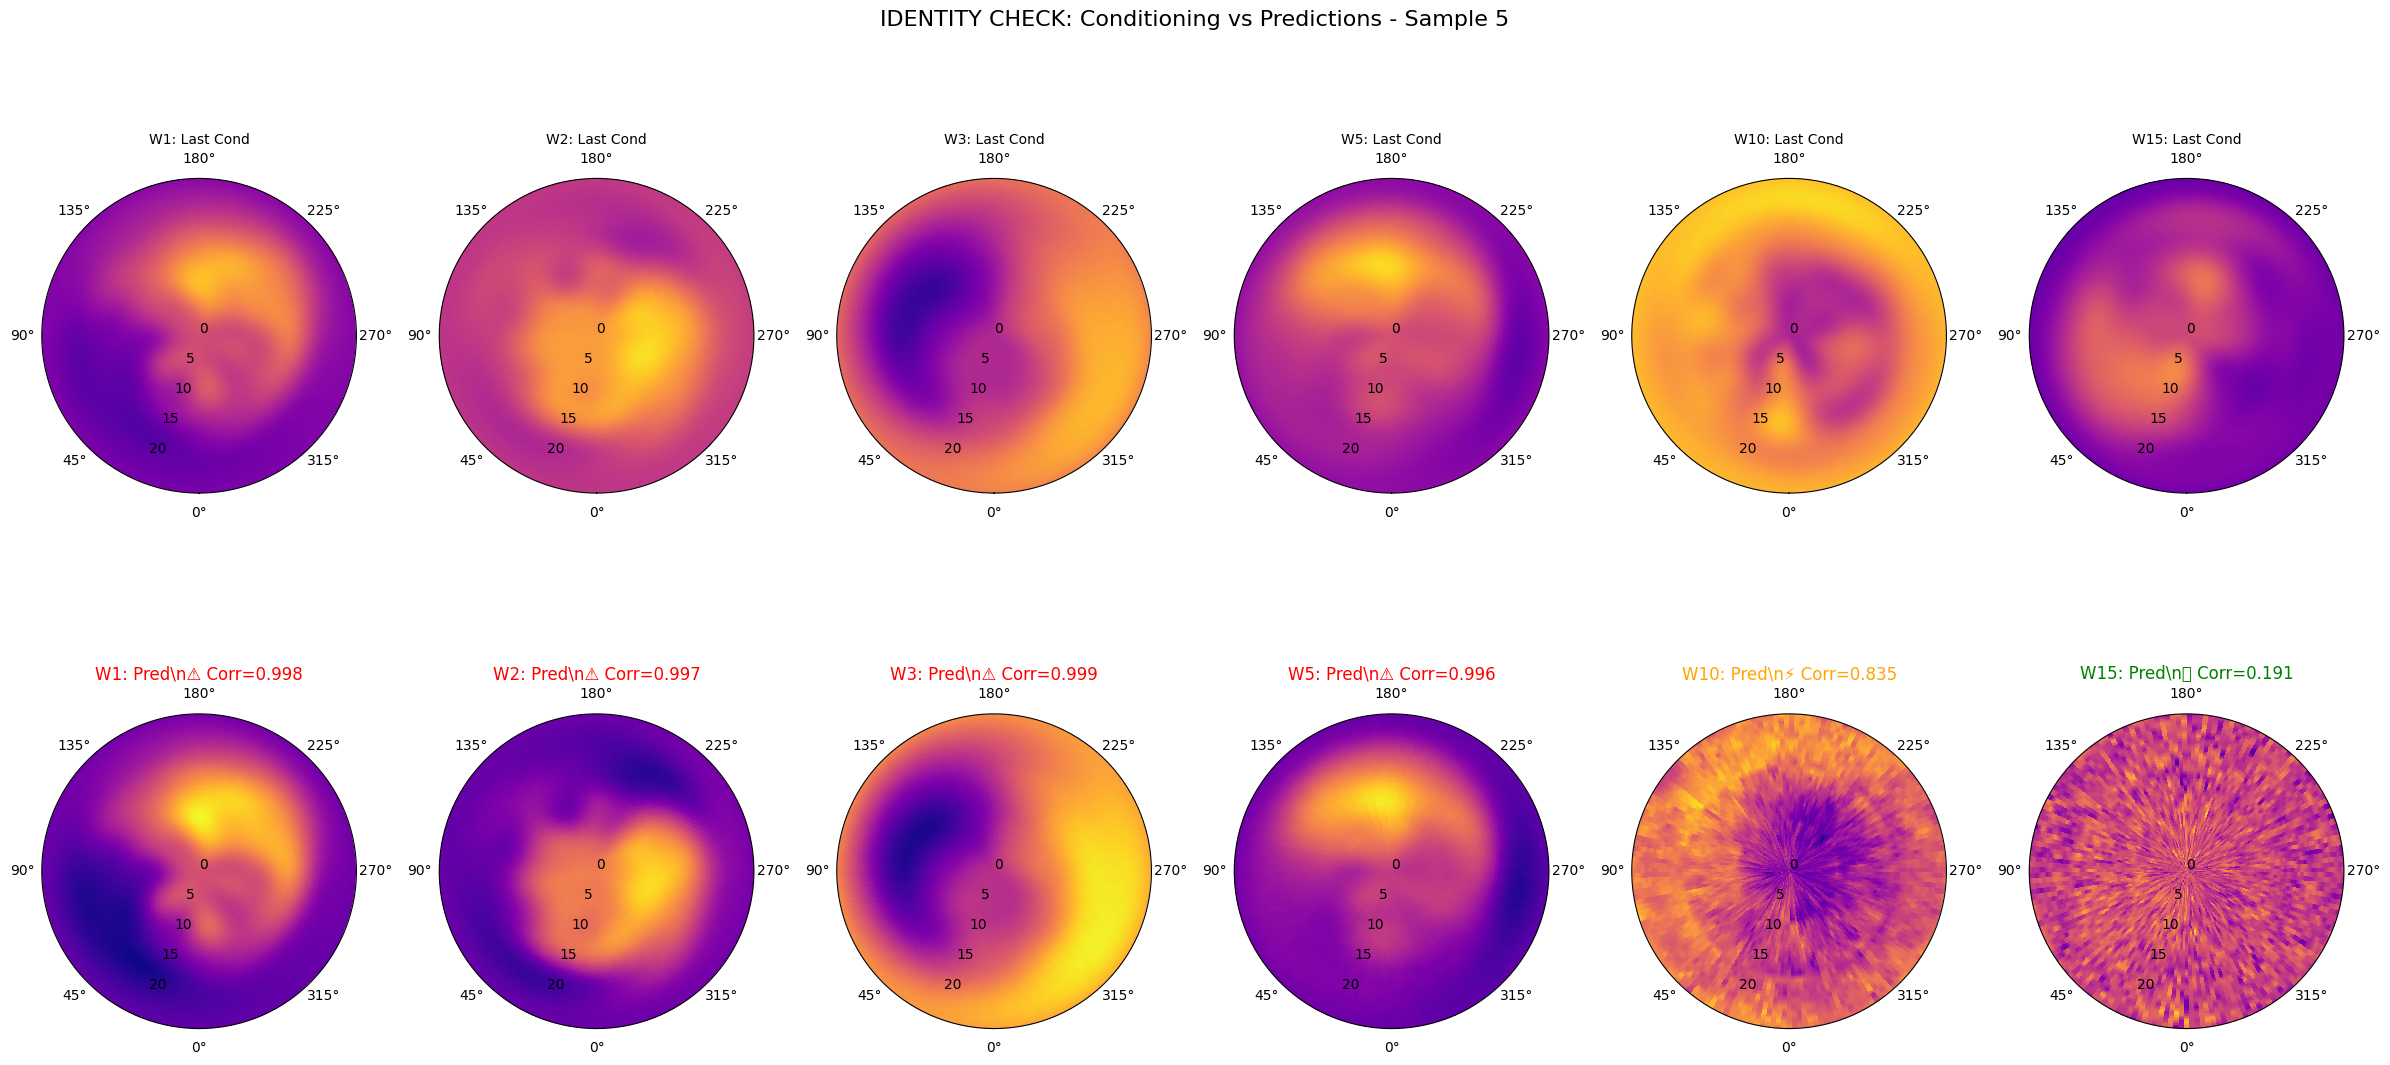

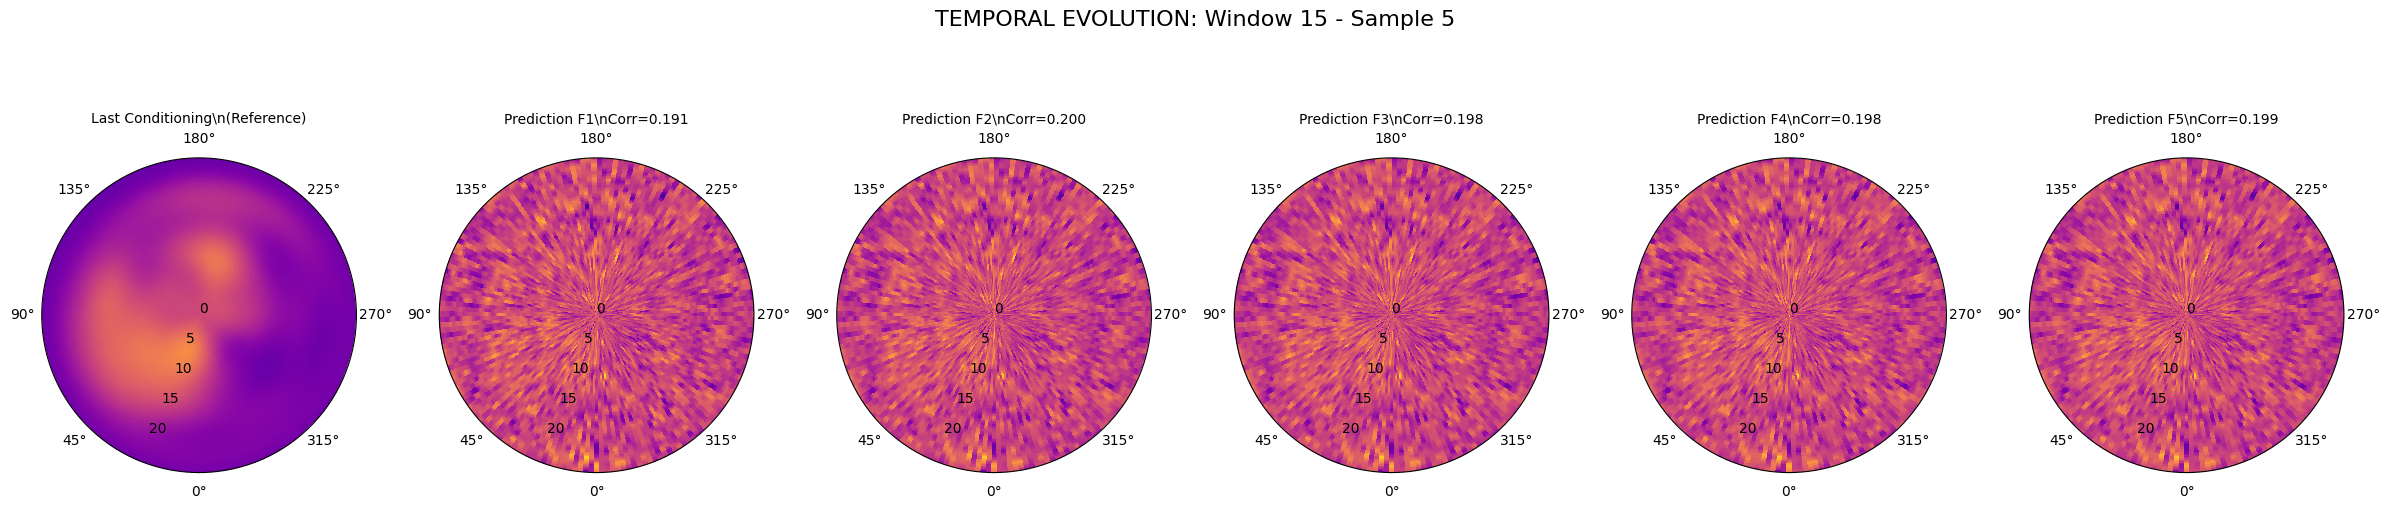

\n📋 IDENTITY CORRELATION SUMMARY:
Window  1: Correlation = 0.998 ⚠️  HIGH IDENTITY RISK
Window  2: Correlation = 0.997 ⚠️  HIGH IDENTITY RISK
Window  3: Correlation = 0.999 ⚠️  HIGH IDENTITY RISK
Window  5: Correlation = 0.996 ⚠️  HIGH IDENTITY RISK
Window 10: Correlation = 0.835 ⚡ MEDIUM IDENTITY RISK
Window 15: Correlation = 0.191 ✅ LOW IDENTITY RISK
\n🚨 SUMMARY:
⚠️  HIGH RISK windows: [1, 2, 3, 5] - Model may be copying inputs!
⚡ MEDIUM RISK windows: [10] - Some similarity to inputs
✅ LOW RISK windows: [15] - Real predictions
\n🔍 Plots saved as: identity_polar_analysis_sample_0005.png
\n✅ Analysis complete for sample 5!
🎯 Identity correlations: {1: 0.9978688, 2: 0.99669904, 3: 0.99926513, 5: 0.99621207, 10: 0.835458, 15: 0.19066718}
\n📊 RISK SUMMARY:
⚠️  HIGH RISK: [1, 2, 3, 5]
⚡ MEDIUM RISK: [10]
✅ LOW RISK: [15]


In [61]:
# RUN IDENTITY CHECK ANALYSIS
target_sample = 5  # Change this to analyze different samples

print("🚀 Running identity check analysis...")
identity_results = analyze_conditioning_vs_predictions(sample_idx=target_sample, save_plots=True)

if identity_results:
    print(f"\\n✅ Analysis complete for sample {target_sample}!")
    print(f"🎯 Identity correlations: {identity_results['identity_correlations']}")
    
    # Show summary
    print(f"\\n📊 RISK SUMMARY:")
    if identity_results['high_risk']:
        print(f"⚠️  HIGH RISK: {identity_results['high_risk']}")
    if identity_results['medium_risk']:
        print(f"⚡ MEDIUM RISK: {identity_results['medium_risk']}")
    if identity_results['low_risk']:
        print(f"✅ LOW RISK: {identity_results['low_risk']}")
else:
    print("❌ Analysis failed!")

In [107]:
def show_conditioning_and_predictions(sample_idx=0, prediction_window=15, save_plots=False):
    """
    Complete function with all plots: conditioning frames, predictions vs ground truth, and min-max evolution.
    """
    print(f"SHOWING: Sample {sample_idx}, Window {prediction_window}")
    print("="*60)
    
    # Load data for the specific window
    if prediction_window not in RESULTS_DIRS:
        print(f"ERROR: Prediction window {prediction_window} not available!")
        print(f"Available windows: {list(RESULTS_DIRS.keys())}")
        return None
    
    data = load_sample_data(RESULTS_DIRS[prediction_window], sample_idx)
    if data is None:
        print(f"ERROR: No data found for sample {sample_idx}!")
        return None
    
    # Extract data
    conditioning_input = revert_normalization(data['conditioning_input'])
    generated_mean = revert_normalization(data['generated_mean'])
    ground_truth = revert_normalization(data['ground_truth'])
    generated_std = revert_normalization(data['generated_std'])
    
    # Get last 5 conditioning frames
    last_5_conditioning = conditioning_input[-5:]
    n_pred_frames = generated_mean.shape[0]
    
    print(f"Conditioning frames: {conditioning_input.shape}")
    print(f"Predicted frames: {generated_mean.shape}")
    
    # Get global scaling for consistency
    all_data = np.concatenate([
        conditioning_input.flatten(),
        generated_mean.flatten(),
        ground_truth.flatten()
    ])
    global_vmin, global_vmax = all_data.min(), all_data.max()
    print(f"Global data range: [{global_vmin:.1f}, {global_vmax:.1f}]")
    
    # ========== PLOT 1: CONDITIONING FRAMES ==========
    plt.figure(figsize=(25, 6))
    
    for i in range(5):
        plt.subplot(1, 6, i+1, projection='polar')
        cond_frame = last_5_conditioning[i]
        c = plot_polar_ionosphere(plt.gca(), cond_frame, 
                                 f'Cond F{-5+i+1}\\n(t={CONDITIONING_FRAMES-5+i+1})', 
                                 vmin=global_vmin, vmax=global_vmax, cmap='plasma')
    
    # Colorbar in the 6th subplot position
    plt.subplot(1, 6, 6)
    plt.axis('off')
    cbar = plt.colorbar(c, ax=plt.gca(), fraction=0.8)
    cbar.set_label('Value', rotation=270, labelpad=20)
    
    plt.suptitle(f'Sample {sample_idx}: Last 5 Conditioning Frames', fontsize=14, y=0.90)
    plt.subplots_adjust(top=0.80, bottom=0.1, left=0.05, right=0.95, wspace=0.3)
    plt.show()
    
    # ========== PLOT 2: PREDICTIONS vs GROUND TRUTH ==========
    fig_height = 10
    fig_width = max(20, 4 * n_pred_frames)
    plt.figure(figsize=(fig_width, fig_height))
    
    # Calculate metrics for all frames first
    correlations = []
    mses = []
    
    for i in range(n_pred_frames):
        pred_flat = generated_mean[i].flatten()
        gt_flat = ground_truth[i].flatten()
        correlations.append(pearsonr(pred_flat, gt_flat)[0])
        mses.append(mean_squared_error(gt_flat, pred_flat))
    
    # Plot predictions (top row)
    for i in range(n_pred_frames):
        plt.subplot(2, n_pred_frames + 1, i + 1, projection='polar')
        c1 = plot_polar_ionosphere(plt.gca(), generated_mean[i],
                                   f'Pred F{i+1}\\nCorr={correlations[i]:.3f}',
                                   vmin=global_vmin, vmax=global_vmax, cmap='plasma')
    
    # Plot ground truth (bottom row)
    for i in range(n_pred_frames):
        plt.subplot(2, n_pred_frames + 1, n_pred_frames + 2 + i, projection='polar')
        c2 = plot_polar_ionosphere(plt.gca(), ground_truth[i],
                                   f'GT F{i+1}\\nMSE={mses[i]:.1f}',
                                   vmin=global_vmin, vmax=global_vmax, cmap='plasma')
    
    # Colorbar in the last column
    plt.subplot(2, n_pred_frames + 1, n_pred_frames + 1)
    plt.axis('off')
    cbar1 = plt.colorbar(c1, ax=plt.gca(), fraction=0.8)
    cbar1.set_label('Generated', rotation=270, labelpad=20)
    
    plt.subplot(2, n_pred_frames + 1, 2 * (n_pred_frames + 1))
    plt.axis('off')
    cbar2 = plt.colorbar(c2, ax=plt.gca(), fraction=0.8)
    cbar2.set_label('Ground Truth', rotation=270, labelpad=20)
    
    plt.suptitle(f'Sample {sample_idx}: Window {prediction_window} Predictions vs Ground Truth', 
                 fontsize=14, y=0.94)
    plt.subplots_adjust(top=0.88, bottom=0.1, left=0.05, right=0.90, wspace=0.3, hspace=0.4)
    plt.show()
    
    # ========== PLOT 3: MIN-MAX EVOLUTION WITH CONTINUOUS LINES ==========
    plt.figure(figsize=(16, 12))
    
    # Calculate min-max values for conditioning frames (last 5)
    cond_mins = [frame.min() for frame in last_5_conditioning]
    cond_maxs = [frame.max() for frame in last_5_conditioning]
    cond_ranges = [maxval - minval for minval, maxval in zip(cond_mins, cond_maxs)]
    cond_timesteps = list(range(CONDITIONING_FRAMES-4, CONDITIONING_FRAMES+1))  # t=11,12,13,14,15
    
    # Calculate min-max values for predictions
    pred_mins = [frame.min() for frame in generated_mean]
    pred_maxs = [frame.max() for frame in generated_mean]
    pred_ranges = [maxval - minval for minval, maxval in zip(pred_mins, pred_maxs)]
    
    # Calculate min-max values for ground truth
    gt_mins = [frame.min() for frame in ground_truth]
    gt_maxs = [frame.max() for frame in ground_truth]
    gt_ranges = [maxval - minval for minval, maxval in zip(gt_mins, gt_maxs)]
    
    pred_timesteps = list(range(CONDITIONING_FRAMES+1, CONDITIONING_FRAMES+1+n_pred_frames))  # t=16,17,18...
    
    # Create connection points at the boundary
    connection_time = [CONDITIONING_FRAMES, CONDITIONING_FRAMES+1]
    
    # Plot 1: Min values evolution
    plt.subplot(2, 2, 1)
    # Plot conditioning as continuous green line
    plt.plot(cond_timesteps, cond_mins, 'g-', linewidth=3, alpha=0.8, label='Conditioning')
    # Connect to predictions with boundary connection
    connection_pred_min = [cond_mins[-1], pred_mins[0]]
    connection_gt_min = [cond_mins[-1], gt_mins[0]]
    plt.plot(connection_time, connection_pred_min, 'b-', alpha=0.8, linewidth=3)
    plt.plot(connection_time, connection_gt_min, 'r-', alpha=0.8, linewidth=3)
    # Plot predictions as continuous lines
    plt.plot(pred_timesteps, pred_mins, 'b-', linewidth=3, alpha=0.8, label='Generated')
    plt.plot(pred_timesteps, gt_mins, 'r-', linewidth=3, alpha=0.8, label='Ground Truth')
    # Add vertical line at x=15 to highlight prediction start
    plt.axvline(x=15, color='black', linestyle='-', linewidth=2, alpha=0.7)
    
    
    plt.xlabel('Timestep')
    plt.ylabel('Min Value')
    plt.title('Minimum Values Evolution')
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Max values evolution
    plt.subplot(2, 2, 2)
    plt.plot(cond_timesteps, cond_maxs, 'g-', linewidth=3, alpha=0.8, label='Conditioning')
    # Connections
    connection_pred_max = [cond_maxs[-1], pred_maxs[0]]
    connection_gt_max = [cond_maxs[-1], gt_maxs[0]]
    plt.plot(connection_time, connection_pred_max, 'b-', alpha=0.8, linewidth=3)
    plt.plot(connection_time, connection_gt_max, 'r-', alpha=0.8, linewidth=3)
    plt.plot(pred_timesteps, pred_maxs, 'b-', linewidth=3, alpha=0.8, label='Generated')
    plt.plot(pred_timesteps, gt_maxs, 'r-', linewidth=3, alpha=0.8, label='Ground Truth')
    # Add vertical line at x=15 to highlight prediction start
    plt.axvline(x=15, color='black', linestyle='-', linewidth=2, alpha=0.7)
    
    
    plt.xlabel('Timestep')
    plt.ylabel('Max Value')
    plt.title('Maximum Values Evolution')
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Range evolution (max - min)
    plt.subplot(2, 2, 3)
    plt.plot(cond_timesteps, cond_ranges, 'g-', linewidth=3, alpha=0.8, label='Conditioning')
    # Connections
    connection_pred_range = [cond_ranges[-1], pred_ranges[0]]
    connection_gt_range = [cond_ranges[-1], gt_ranges[0]]
    plt.plot(connection_time, connection_pred_range, 'b-', alpha=0.8, linewidth=3)
    plt.plot(connection_time, connection_gt_range, 'r-', alpha=0.8, linewidth=3)
    plt.plot(pred_timesteps, pred_ranges, 'b-', linewidth=3, alpha=0.8, label='Generated')
    plt.plot(pred_timesteps, gt_ranges, 'r-', linewidth=3, alpha=0.8, label='Ground Truth')
    
    # Add vertical line at x=15 to highlight prediction start
    plt.axvline(x=15, color='black', linestyle='-', linewidth=2, alpha=0.7)
    
    plt.xlabel('Timestep')
    plt.ylabel('Range (Max - Min)')
    plt.title('Value Range Evolution')
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Prediction quality over time (correlation and MSE)
    plt.subplot(2, 2, 4)
    ax4_left = plt.gca()
    ax4_right = ax4_left.twinx()
    
    # For single point predictions, use scatter plot; for multiple points, use line plot
    if len(pred_timesteps) == 1:
        # Single prediction frame - use scatter plots
        line1 = ax4_left.scatter(pred_timesteps, correlations, c='blue', s=100, alpha=0.8, label='Correlation')
        line2 = ax4_right.scatter(pred_timesteps, mses, c='red', s=100, alpha=0.8, label='MSE', marker='s')
    else:
        # Multiple prediction frames - use line plots
        line1 = ax4_left.plot(pred_timesteps, correlations, 'b-', linewidth=3, alpha=0.8, label='Correlation')
        line2 = ax4_right.plot(pred_timesteps, mses, 'r-', linewidth=3, alpha=0.8, label='MSE')
    
    ax4_left.set_xlabel('Timestep')
    ax4_left.set_ylabel('Correlation', color='blue')
    ax4_left.tick_params(axis='y', labelcolor='blue')
    ax4_left.set_ylim(-0.1, 1.1)
    
    ax4_right.set_ylabel('MSE', color='red')
    ax4_right.tick_params(axis='y', labelcolor='red')
    
    plt.title('Prediction Quality Over Time')
    ax4_left.grid(True, alpha=0.3)
    
    # Combined legend - handle both scatter and line plots
    if len(pred_timesteps) == 1:
        # For scatter plots, create manual legend entries
        ax4_left.legend([line1], ['Correlation'], loc='upper left')
        ax4_right.legend([line2], ['MSE'], loc='upper right')
    else:
        # For line plots, use the original approach
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax4_left.legend(lines, labels, loc='upper right')
    
    plt.suptitle(f'Sample {sample_idx}: Evolution Analysis (Window {prediction_window})', 
                 fontsize=14, y=0.96)
    plt.tight_layout(rect=[0, 0, 1, 0.94])
    plt.show()
    
    if save_plots:
        plt.figure(1)
        plt.savefig(f"conditioning_sample_{sample_idx:04d}.png", dpi=300, bbox_inches='tight')
        plt.figure(2)
        plt.savefig(f"predictions_sample_{sample_idx:04d}_window_{prediction_window:02d}.png", 
                   dpi=300, bbox_inches='tight')
        plt.figure(3)
        plt.savefig(f"minmax_evolution_sample_{sample_idx:04d}_window_{prediction_window:02d}.png", 
                   dpi=300, bbox_inches='tight')
        print(f"All plots saved")
    
    # Print summary
    print("\\nPREDICTION SUMMARY:")
    print("="*40)
    
    for i in range(n_pred_frames):
        uncertainty = generated_std[i].mean()
        print(f"Frame {i+1}: Corr={correlations[i]:.3f}, MSE={mses[i]:.1f}, Uncertainty={uncertainty:.1f}")
    
    print("\\nMIN-MAX EVOLUTION SUMMARY:")
    print("="*40)
    print(f"Conditioning range: [{min(cond_mins):.1f}, {max(cond_maxs):.1f}] (avg range: {np.mean(cond_ranges):.1f})")
    print(f"Generated range: [{min(pred_mins):.1f}, {max(pred_maxs):.1f}] (avg range: {np.mean(pred_ranges):.1f})")
    print(f"Ground truth range: [{min(gt_mins):.1f}, {max(gt_maxs):.1f}] (avg range: {np.mean(gt_ranges):.1f})")
    
    return {
        'sample_idx': sample_idx,
        'prediction_window': prediction_window,
        'conditioning_shape': conditioning_input.shape,
        'prediction_shape': generated_mean.shape,
        'global_range': (float(global_vmin), float(global_vmax)),
        'correlations': correlations,
        'mses': mses,
        'minmax_evolution': {
            'conditioning': {'timesteps': cond_timesteps, 'mins': cond_mins, 'maxs': cond_maxs, 'ranges': cond_ranges},
            'generated': {'timesteps': pred_timesteps, 'mins': pred_mins, 'maxs': pred_maxs, 'ranges': pred_ranges},
            'ground_truth': {'timesteps': pred_timesteps, 'mins': gt_mins, 'maxs': gt_maxs, 'ranges': gt_ranges}
        }
    }

print("COMPLETE conditioning + predictions viewer with ALL PLOTS ready!")

COMPLETE conditioning + predictions viewer with ALL PLOTS ready!


🚀 Showing Sample 63, Window 1
SHOWING: Sample 63, Window 1
Conditioning frames: (15, 24, 360)
Predicted frames: (1, 24, 360)
Global data range: [-14350.2, 9099.8]


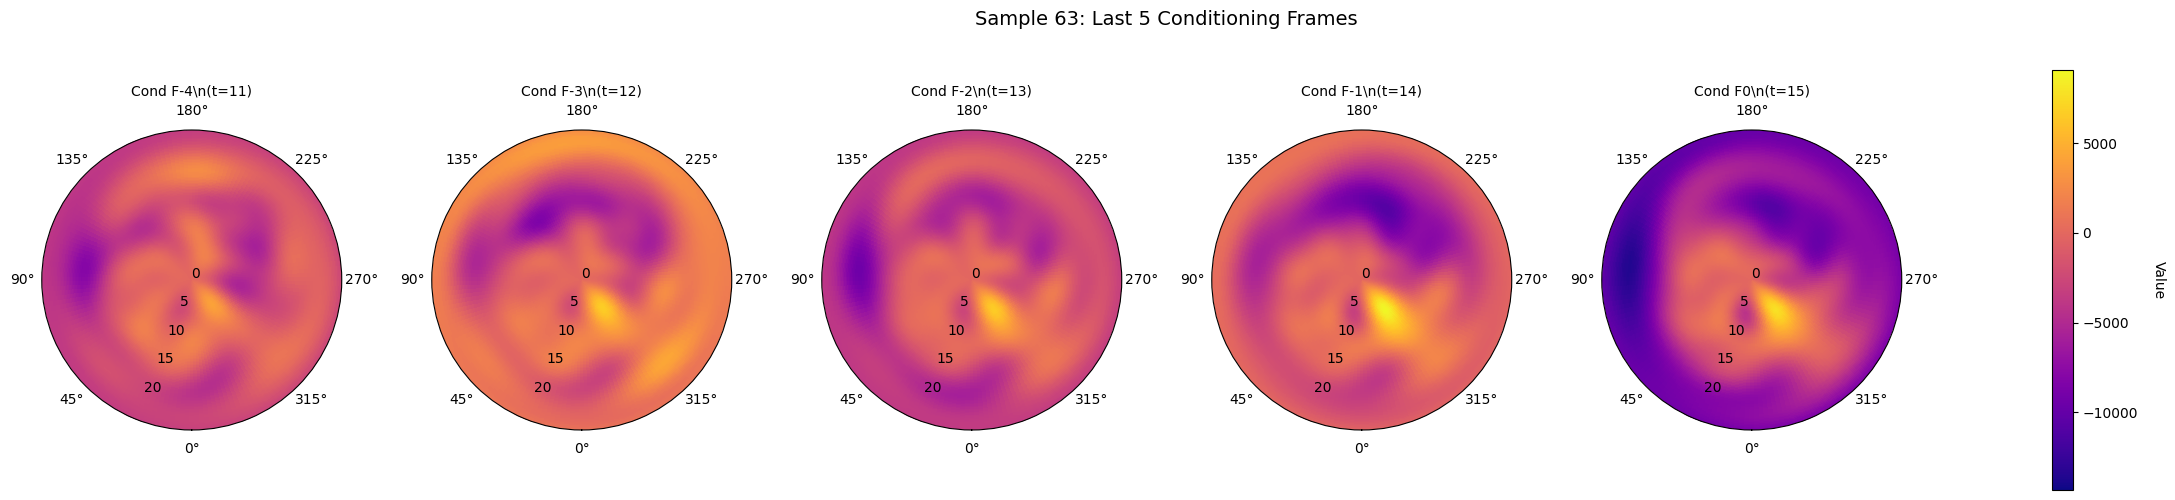

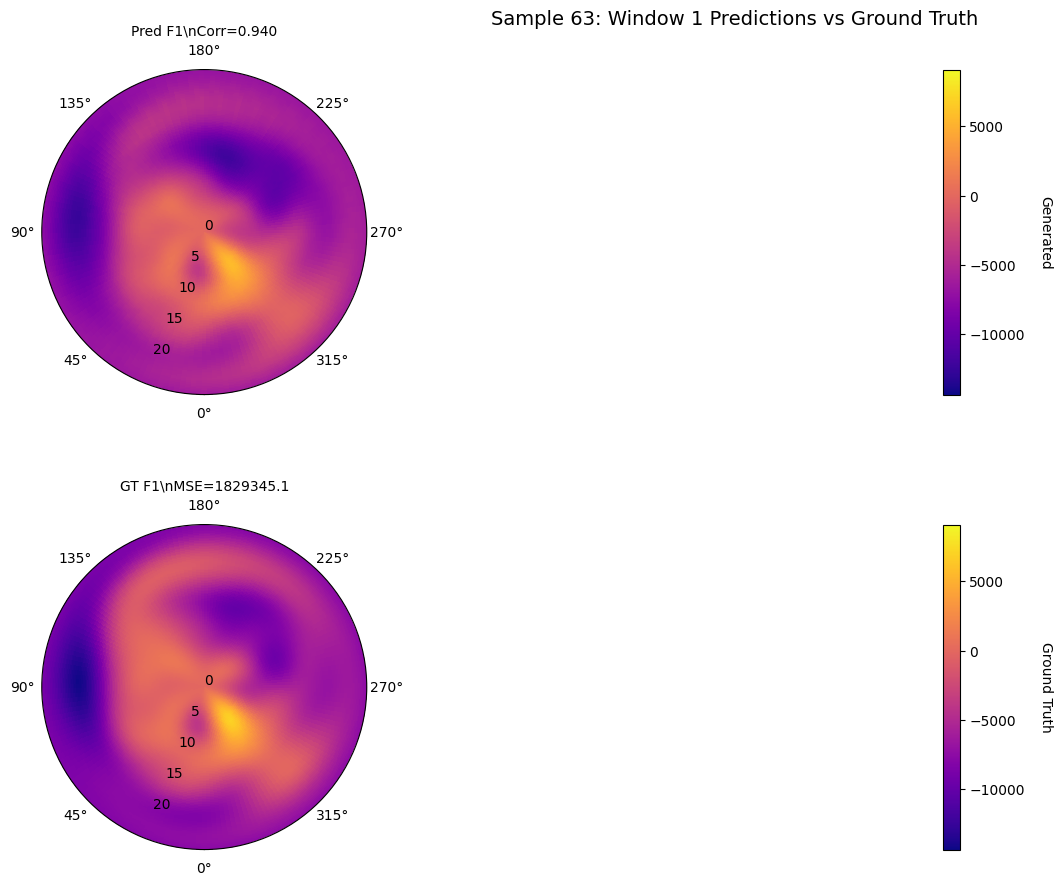

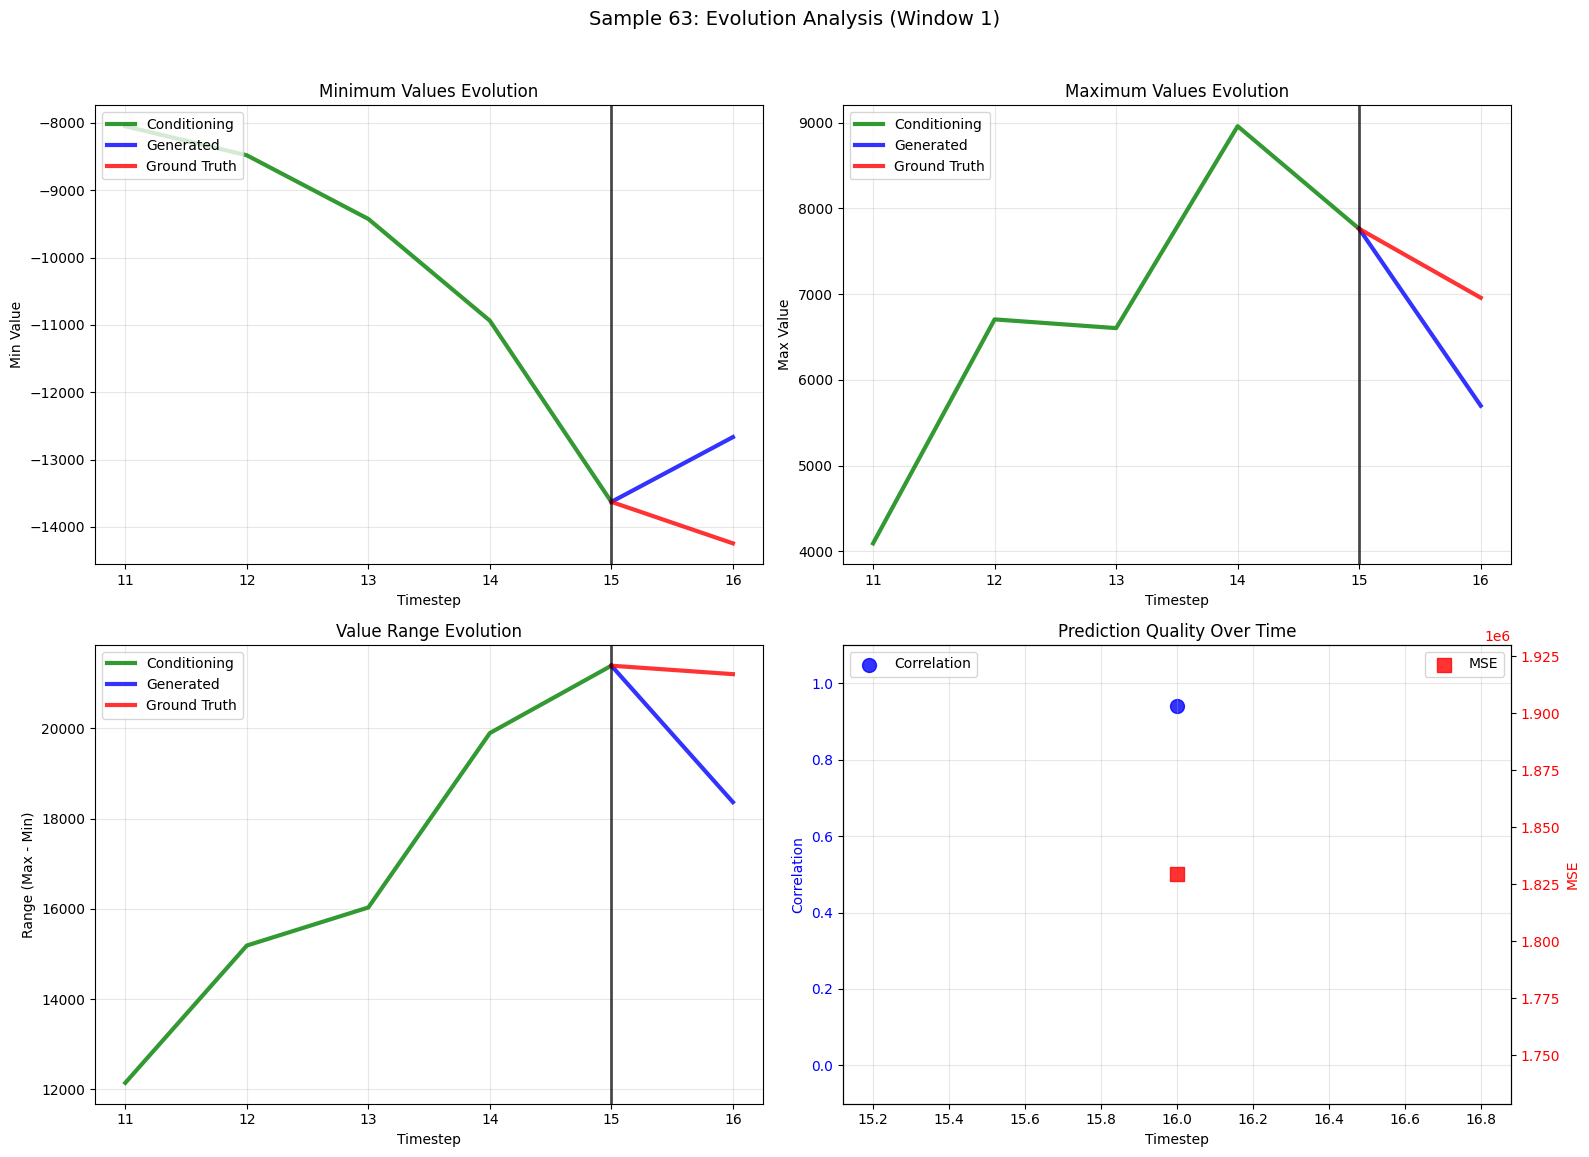

\nPREDICTION SUMMARY:
Frame 1: Corr=0.940, MSE=1829345.1, Uncertainty=2701.4
\nMIN-MAX EVOLUTION SUMMARY:
Conditioning range: [-13629.0, 8957.4] (avg range: 16928.6)
Generated range: [-12666.7, 5697.6] (avg range: 18364.3)
Ground truth range: [-14244.9, 6957.0] (avg range: 21201.8)
\n✅ Successfully displayed sample 63 with window 1
📊 Conditioning: (15, 24, 360)
📊 Predictions: (1, 24, 360)


In [108]:
# 🎯 INTERACTIVE: Choose Sample and Prediction Window
# Change these values to explore different samples and windows

SAMPLE_TO_SHOW = np.random.randint(100)        # Which sample (0-99)
PREDICTION_WINDOW = 1    # Which window (1, 2, 3, 5, 10, 15)
SAVE_PLOT = False         # Set to True to save the plot

print(f"🚀 Showing Sample {SAMPLE_TO_SHOW}, Window {PREDICTION_WINDOW}")
result = show_conditioning_and_predictions(
    sample_idx=SAMPLE_TO_SHOW, 
    prediction_window=PREDICTION_WINDOW, 
    save_plots=SAVE_PLOT
)

if result:
    print(f"\\n✅ Successfully displayed sample {SAMPLE_TO_SHOW} with window {PREDICTION_WINDOW}")
    print(f"📊 Conditioning: {result['conditioning_shape']}")
    print(f"📊 Predictions: {result['prediction_shape']}")
else:
    print("❌ Failed to display the requested sample/window")

In [81]:
def analyze_conditioning_vs_predictions(sample_idx=0, save_plots=True):
    """
    Comprehensive analysis to detect if model is acting as identity function.
    
    Compares predictions vs conditioning frames both visually and numerically
    to detect if the model is just copying inputs vs making real predictions.
    """
    print(f"🔍 IDENTITY CHECK ANALYSIS - Sample {sample_idx}")
    print(f"{'='*60}")
    
    # Load data for all prediction windows
    all_sample_data = {}
    for pred_window in RESULTS_DIRS.keys():
        data = load_sample_data(RESULTS_DIRS[pred_window], sample_idx)
        if data is not None:
            all_sample_data[pred_window] = data
    
    if not all_sample_data:
        print("❌ No data found for the specified sample!")
        return None
    
    available_windows = sorted(all_sample_data.keys())
    print(f"📊 Available windows: {available_windows}")
    
    # Create comprehensive comparison figure
    fig, axes = plt.subplots(3, 4, figsize=(24, 18))
    fig.suptitle(f'Conditioning vs Predictions Analysis - Sample {sample_idx}', fontsize=18)
    
    identity_metrics = {}
    
    for pred_window in available_windows:
        data = all_sample_data[pred_window]
        conditioning_input = revert_normalization(data['conditioning_input'])
        generated_mean = revert_normalization(data['generated_mean'])
        ground_truth = revert_normalization(data['ground_truth'])
        
        # Get last conditioning frame for comparison (frame -1)
        last_conditioning_frame = conditioning_input[-1]  # Shape: [24, 360]
        
        # Compare predictions to last conditioning frame
        metrics_vs_conditioning = {
            'frame_indices': [],
            'pred_vs_cond_corr': [],      # Correlation with last conditioning frame
            'pred_vs_cond_mse': [],       # MSE with last conditioning frame
            'pred_vs_cond_rms': [],       # RMS difference from conditioning
            'gt_vs_cond_corr': [],        # GT correlation with conditioning
            'gt_vs_cond_mse': [],         # GT MSE with conditioning
            'gt_vs_cond_rms': [],         # GT RMS difference from conditioning
            'pred_vs_gt_corr': [],        # Actual prediction performance
            'pred_vs_gt_mse': []          # Actual prediction MSE
        }
        
        for frame_idx in range(min(generated_mean.shape[0], ground_truth.shape[0])):
            pred_frame = generated_mean[frame_idx]
            gt_frame = ground_truth[frame_idx]
            
            # Flatten for correlation calculation
            last_cond_flat = last_conditioning_frame.flatten()
            pred_flat = pred_frame.flatten()
            gt_flat = gt_frame.flatten()
            
            # Calculate metrics vs conditioning frame
            pred_vs_cond_corr = pearsonr(pred_flat, last_cond_flat)[0]
            pred_vs_cond_mse = mean_squared_error(last_cond_flat, pred_flat)
            pred_vs_cond_rms = np.sqrt(np.mean((pred_flat - last_cond_flat) ** 2))
            
            gt_vs_cond_corr = pearsonr(gt_flat, last_cond_flat)[0]
            gt_vs_cond_mse = mean_squared_error(last_cond_flat, gt_flat)
            gt_vs_cond_rms = np.sqrt(np.mean((gt_flat - last_cond_flat) ** 2))
            
            # Calculate actual prediction performance
            pred_vs_gt_corr = pearsonr(pred_flat, gt_flat)[0]
            pred_vs_gt_mse = mean_squared_error(gt_flat, pred_flat)
            
            metrics_vs_conditioning['frame_indices'].append(frame_idx)
            metrics_vs_conditioning['pred_vs_cond_corr'].append(pred_vs_cond_corr)
            metrics_vs_conditioning['pred_vs_cond_mse'].append(pred_vs_cond_mse)
            metrics_vs_conditioning['pred_vs_cond_rms'].append(pred_vs_cond_rms)
            metrics_vs_conditioning['gt_vs_cond_corr'].append(gt_vs_cond_corr)
            metrics_vs_conditioning['gt_vs_cond_mse'].append(gt_vs_cond_mse)
            metrics_vs_conditioning['gt_vs_cond_rms'].append(gt_vs_cond_rms)
            metrics_vs_conditioning['pred_vs_gt_corr'].append(pred_vs_gt_corr)
            metrics_vs_conditioning['pred_vs_gt_mse'].append(pred_vs_gt_mse)
        
        identity_metrics[pred_window] = metrics_vs_conditioning
    
    # Plot 1: Correlation with last conditioning frame
    ax = axes[0, 0]
    for pred_window in available_windows:
        metrics = identity_metrics[pred_window]
        ax.plot(metrics['frame_indices'], metrics['pred_vs_cond_corr'], 'o-', 
                label=f'Pred W{pred_window}', linewidth=2)
        ax.plot(metrics['frame_indices'], metrics['gt_vs_cond_corr'], '--', 
                alpha=0.7, label=f'GT W{pred_window}')
    
    ax.axhline(y=0.9, color='red', linestyle=':', alpha=0.7, label='High Similarity (0.9)')
    ax.set_xlabel('Prediction Frame')
    ax.set_ylabel('Correlation with Last Conditioning Frame')
    ax.set_title('Correlation vs Last Conditioning Frame\\n(High = Potential Identity)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Plot 2: RMS difference from conditioning
    ax = axes[0, 1]
    for pred_window in available_windows:
        metrics = identity_metrics[pred_window]
        ax.plot(metrics['frame_indices'], metrics['pred_vs_cond_rms'], 'o-', 
                label=f'Pred W{pred_window}', linewidth=2)
        ax.plot(metrics['frame_indices'], metrics['gt_vs_cond_rms'], '--', 
                alpha=0.7, label=f'GT W{pred_window}')
    
    ax.set_xlabel('Prediction Frame')
    ax.set_ylabel('RMS Difference from Last Conditioning')
    ax.set_title('RMS Difference vs Last Conditioning\\n(Low = Potential Identity)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
    
    # Plot 3: Identity vs Prediction Performance Ratio
    ax = axes[0, 2]
    for pred_window in available_windows:
        metrics = identity_metrics[pred_window]
        # Calculate ratio: how much does prediction correlate with conditioning vs ground truth
        identity_ratio = np.array(metrics['pred_vs_cond_corr']) / (np.array(metrics['pred_vs_gt_corr']) + 1e-8)
        ax.plot(metrics['frame_indices'], identity_ratio, 'o-', 
                label=f'W{pred_window}', linewidth=2)
    
    ax.axhline(y=1.0, color='red', linestyle=':', alpha=0.7, label='Identity Threshold')
    ax.set_xlabel('Prediction Frame')
    ax.set_ylabel('Corr(Pred,Cond) / Corr(Pred,GT)')
    ax.set_title('Identity Ratio\\n(>1 = More similar to conditioning)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Summary statistics
    ax = axes[0, 3]
    ax.axis('off')
    
    # Create identity summary table
    table_data = []
    for pred_window in available_windows:
        metrics = identity_metrics[pred_window]
        avg_identity_corr = np.mean(metrics['pred_vs_cond_corr'])
        avg_pred_corr = np.mean(metrics['pred_vs_gt_corr'])
        avg_identity_rms = np.mean(metrics['pred_vs_cond_rms'])
        identity_score = avg_identity_corr / (avg_pred_corr + 1e-8)
        
        # Classify identity behavior
        if avg_identity_corr > 0.85 and identity_score > 0.8:
            identity_status = "⚠️ HIGH"
        elif avg_identity_corr > 0.7 and identity_score > 0.6:
            identity_status = "⚡ MED"
        else:
            identity_status = "✅ LOW"
        
        table_data.append([
            f"W{int(pred_window)}",
            f"{avg_identity_corr:.3f}",
            f"{avg_pred_corr:.3f}",
            f"{identity_score:.2f}",
            identity_status
        ])
    
    table = ax.table(cellText=table_data,
                    colLabels=['Window', 'Cond Corr', 'Pred Corr', 'Ratio', 'Identity'],
                    cellLoc='center',
                    loc='center',
                    bbox=[0, 0, 1, 1])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    ax.set_title('Identity Risk Assessment\\n(HIGH = Model copying inputs)')
    
    # Plot 5-8: Visual comparison for first 4 windows
    for i, pred_window in enumerate(available_windows[:4]):
        row = 1
        col = i
        ax = axes[row, col]
        
        data = all_sample_data[pred_window]
        conditioning_input = revert_normalization(data['conditioning_input'])
        generated_mean = revert_normalization(data['generated_mean'])
        ground_truth = revert_normalization(data['ground_truth'])
        
        # Show scatter plot: last conditioning vs first prediction
        last_cond_flat = conditioning_input[-1].flatten()
        first_pred_flat = generated_mean[0].flatten()
        first_gt_flat = ground_truth[0].flatten()
        
        # Sample points for visualization (to avoid too many points)
        n_points = 1000
        indices = np.random.choice(len(last_cond_flat), n_points, replace=False)
        
        ax.scatter(last_cond_flat[indices], first_pred_flat[indices], 
                  alpha=0.5, s=10, label='Pred vs Cond', color='blue')
        ax.scatter(last_cond_flat[indices], first_gt_flat[indices], 
                  alpha=0.5, s=10, label='GT vs Cond', color='red')
        
        # Add identity line
        min_val = min(last_cond_flat.min(), first_pred_flat.min(), first_gt_flat.min())
        max_val = max(last_cond_flat.max(), first_pred_flat.max(), first_gt_flat.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.7, label='Identity Line')
        
        # Calculate correlation for title
        pred_corr = pearsonr(last_cond_flat, first_pred_flat)[0]
        gt_corr = pearsonr(last_cond_flat, first_gt_flat)[0]
        
        ax.set_xlabel('Last Conditioning Frame Value')
        ax.set_ylabel('First Prediction Frame Value')
        ax.set_title(f'W{pred_window}: Pred_corr={pred_corr:.3f}, GT_corr={gt_corr:.3f}')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    # Plot 9-12: Difference maps for remaining windows or detailed analysis
    for i, pred_window in enumerate(available_windows[-4:]):
        row = 2
        col = i
        ax = axes[row, col]
        
        data = all_sample_data[pred_window]
        conditioning_input = revert_normalization(data['conditioning_input'])
        generated_mean = revert_normalization(data['generated_mean'])
        
        # Show difference map: |prediction - last_conditioning|
        last_cond = conditioning_input[-1]
        first_pred = generated_mean[0]
        diff_map = np.abs(first_pred - last_cond)
        
        im = ax.imshow(diff_map, cmap='Reds', aspect='auto')
        plt.colorbar(im, ax=ax, shrink=0.8)
        ax.set_title(f'W{pred_window}: |Pred - Last Cond|\\nMean Diff: {diff_map.mean():.1f}')
        ax.set_xlabel('Longitude')\n        ax.set_ylabel('Latitude')
    
    plt.tight_layout()
    
    if save_plots:
        plot_filename = f"identity_analysis_sample_{sample_idx:04d}.png"
        plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
        print(f"🔍 Identity analysis saved: {plot_filename}")
    
    plt.show()
    
    # Print detailed summary
    print(f"\\n📋 IDENTITY ANALYSIS SUMMARY - Sample {sample_idx}")
    print(f"{'='*60}")
    
    for pred_window in available_windows:
        metrics = identity_metrics[pred_window]
        avg_identity_corr = np.mean(metrics['pred_vs_cond_corr'])
        avg_pred_corr = np.mean(metrics['pred_vs_gt_corr'])
        avg_identity_rms = np.mean(metrics['pred_vs_cond_rms'])
        identity_score = avg_identity_corr / (avg_pred_corr + 1e-8)
        
        print(f"\\n🎯 Window {pred_window}:")
        print(f"  Pred-Conditioning Correlation: {avg_identity_corr:.3f}")
        print(f"  Pred-GroundTruth Correlation: {avg_pred_corr:.3f}")
        print(f"  Identity Score (ratio): {identity_score:.2f}")
        print(f"  RMS diff from conditioning: {avg_identity_rms:.1f}")
        
        if avg_identity_corr > 0.85 and identity_score > 0.8:
            print(f"  ⚠️  HIGH IDENTITY RISK - Model may be copying inputs!")
        elif avg_identity_corr > 0.7 and identity_score > 0.6:
            print(f"  ⚡ MEDIUM IDENTITY RISK - Some similarity to inputs")
        else:
            print(f"  ✅ LOW IDENTITY RISK - Model making real predictions")
    
    return {
        'sample_idx': sample_idx,
        'available_windows': available_windows,
        'identity_metrics': identity_metrics,
        'summary': {w: {
            'avg_identity_corr': np.mean(identity_metrics[w]['pred_vs_cond_corr']),
            'avg_pred_corr': np.mean(identity_metrics[w]['pred_vs_gt_corr']),
            'identity_score': np.mean(identity_metrics[w]['pred_vs_cond_corr']) / (np.mean(identity_metrics[w]['pred_vs_gt_corr']) + 1e-8)
        } for w in available_windows}
    }

print("🔍 Identity check analysis function ready!")

SyntaxError: unexpected character after line continuation character (3400268261.py, line 233)